In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

In [ ]:
df = load_dataset('SamuelM0422/Hourly-Electricity-Demand-Brazil-Dataset')

In [ ]:
df = df['train'].to_pandas()
df.head(3)

id_subsistema nom_subsistema din_instante  val_cargaenergiahomwmed
0             N          NORTE   2020-01-01                 4889.146
1            NE       NORDESTE   2020-01-01                 9617.975
2             S            SUL   2020-01-01                10013.742

In [ ]:
df.tail(3)

id_subsistema nom_subsistema        din_instante  \
185277            NE       NORDESTE 2025-04-13 23:00:00   
185278             S            SUL 2025-04-13 23:00:00   
185279            SE        SUDESTE 2025-04-13 23:00:00   

        val_cargaenergiahomwmed  
185277                14180.622  
185278                10645.178  
185279                42233.041

In [ ]:
df.sample(3)

id_subsistema nom_subsistema        din_instante  \
160773            NE       NORDESTE 2024-08-01 17:00:00   
102899            SE        SUDESTE 2022-12-07 20:00:00   
169067            SE        SUDESTE 2024-10-27 02:00:00   

        val_cargaenergiahomwmed  
160773                13569.831  
102899                47852.639  
169067                36768.877

In [ ]:
df.shape

(185280, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185280 entries, 0 to 185279
Data columns (total 4 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   id_subsistema            185280 non-null  object        
 1   nom_subsistema           185280 non-null  object        
 2   din_instante             185280 non-null  datetime64[ns]
 3   val_cargaenergiahomwmed  185280 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 5.7+ MB


In [ ]:
df.describe()

din_instante  val_cargaenergiahomwmed
count               185280            185280.000000
mean   2022-08-22 23:30:00             17864.746963
min    2020-01-01 00:00:00              1364.251000
25%    2021-04-27 11:45:00              8305.540000
50%    2022-08-22 23:30:00             11949.707500
75%    2023-12-18 11:15:00             22195.426000
max    2025-04-13 23:00:00             62115.012000
std                    NaN             13878.393120

In [ ]:
df.isna().sum()

id_subsistema              0
nom_subsistema             0
din_instante               0
val_cargaenergiahomwmed    0
dtype: int64

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.nunique()

id_subsistema                   4
nom_subsistema                  4
din_instante                46320
val_cargaenergiahomwmed    184761
dtype: int64

In [ ]:
df.set_index('din_instante',inplace=True)
df.head(1)

id_subsistema nom_subsistema  val_cargaenergiahomwmed
din_instante                                                      
2020-01-01               N          NORTE                 4889.146

In [ ]:
 regions = df.id_subsistema.unique()
 regions

array(['N', 'NE', 'S', 'SE'], dtype=object)

In [ ]:
N = df[df['id_subsistema'] == 'N'].copy()
NE = df[df['id_subsistema'] == 'NE'].copy()
S = df[df['id_subsistema'] == 'S'].copy()
SE = df[df['id_subsistema'] == 'SE'].copy()

In [ ]:
Regions = [N, NE, S, SE]
def rename_target():
  for r in Regions:
    r.rename(columns={'val_cargaenergiahomwmed': 'load'}, inplace=True)
rename_target()

In [ ]:
N.head(1)

id_subsistema nom_subsistema      load
din_instante                                       
2020-01-01               N          NORTE  4889.146

#  EDA for each region

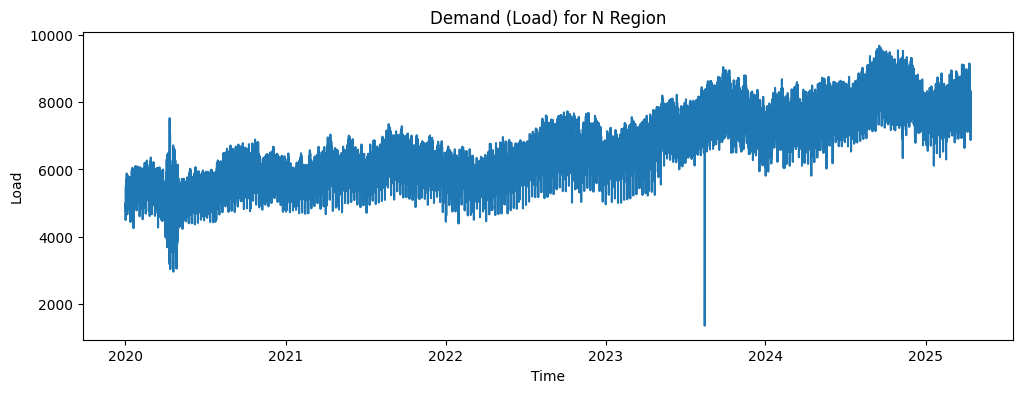

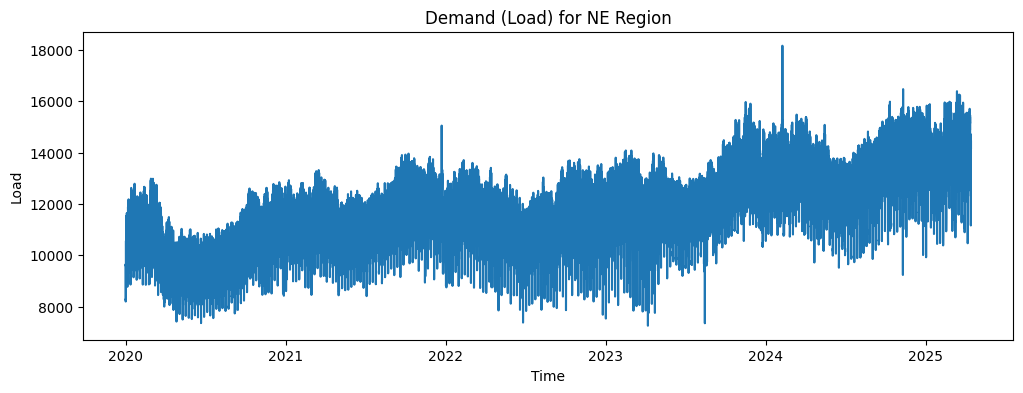

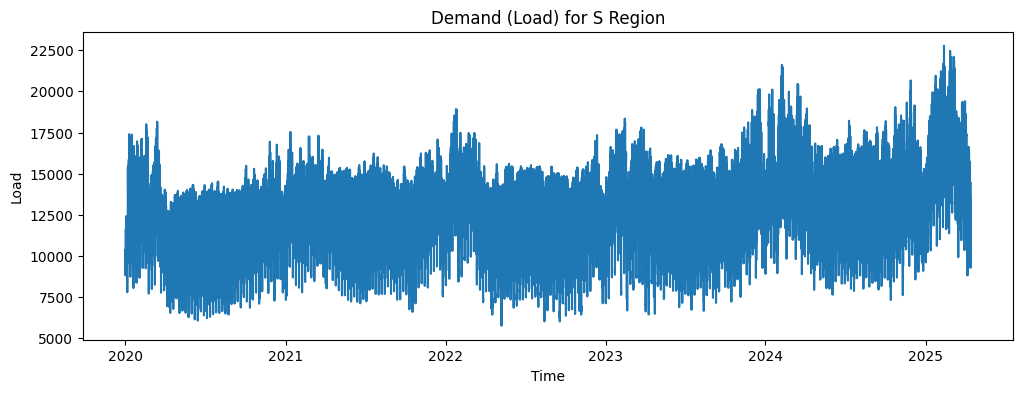

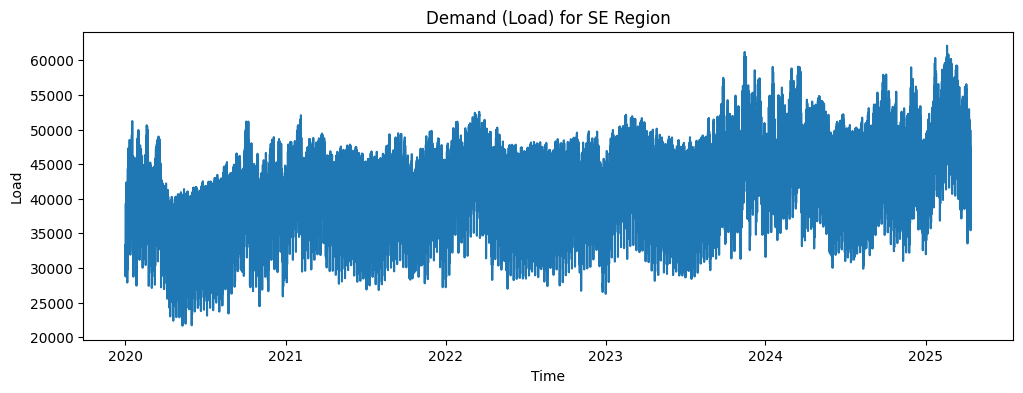

In [ ]:
Regions = {
    'N': N,
    'NE': NE,
    'S': S,
    'SE': SE
}
def draw_lineplots(regions_dict):
    for name, r in regions_dict.items():
        plt.figure(figsize=(12,4))
        sns.lineplot(x=r.index, y=r['load'])
        plt.title(f"Demand (Load) for {name} Region")
        plt.xlabel("Time")
        plt.ylabel("Load")
        plt.show()
draw_lineplots(Regions)

**conclusion** differnt behaviour for each region/
one model for all regions doesnot make any sense

# Resampling

/tmp/ipython-input-3218227919.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  region['load'].resample('M').mean().plot(title=f"{name} - Monthly Mean")


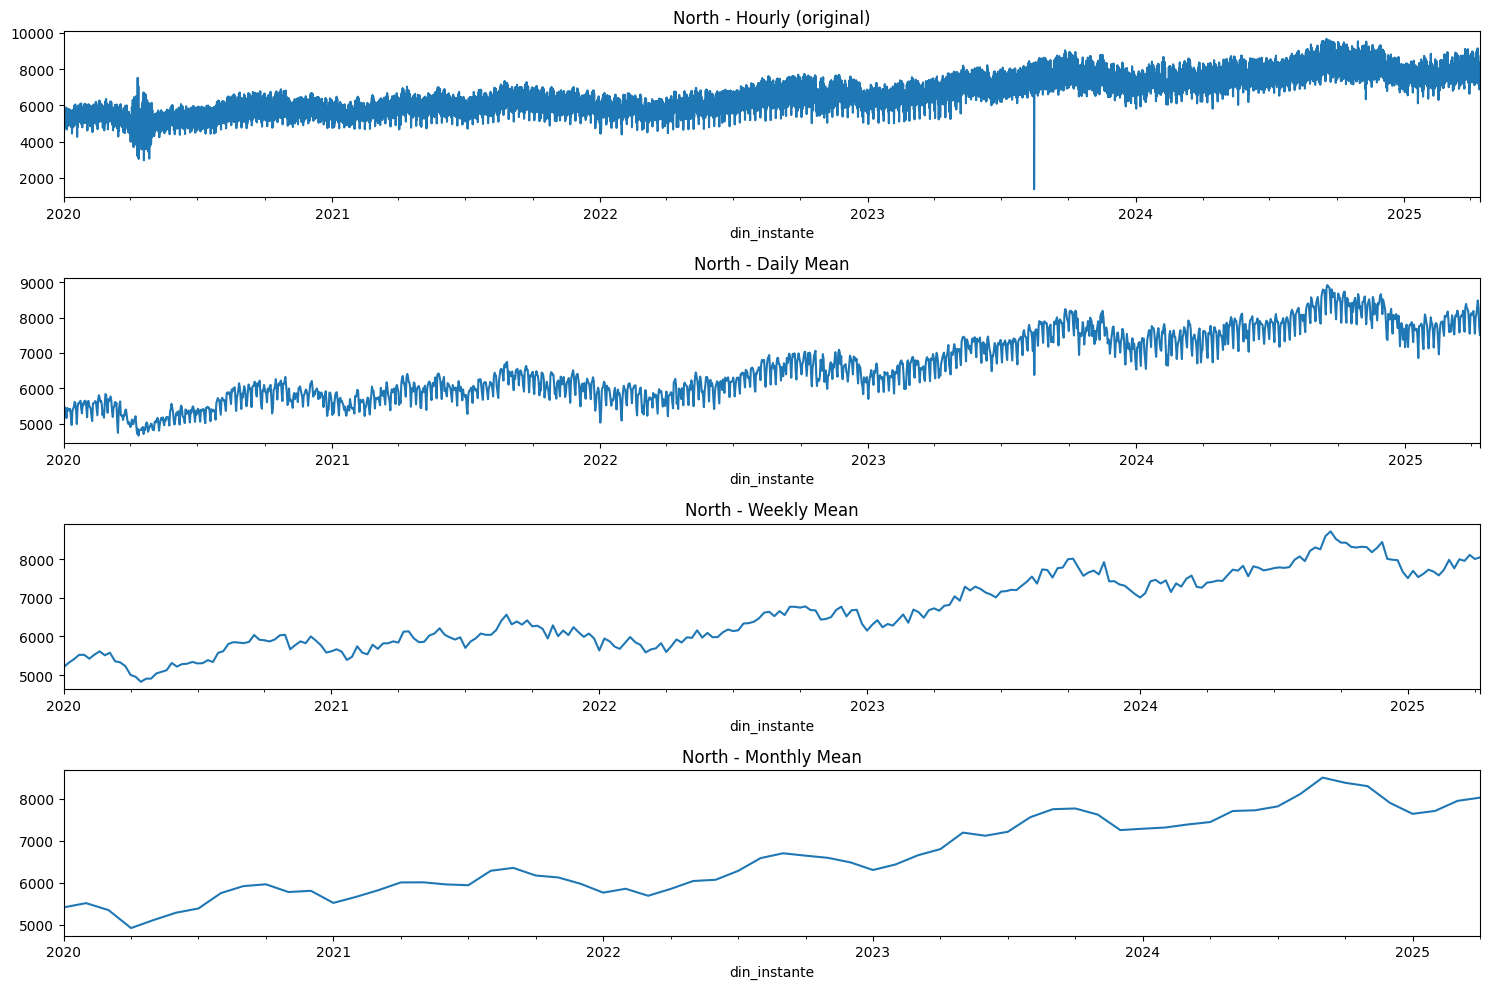

/tmp/ipython-input-3218227919.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  region['load'].resample('M').mean().plot(title=f"{name} - Monthly Mean")


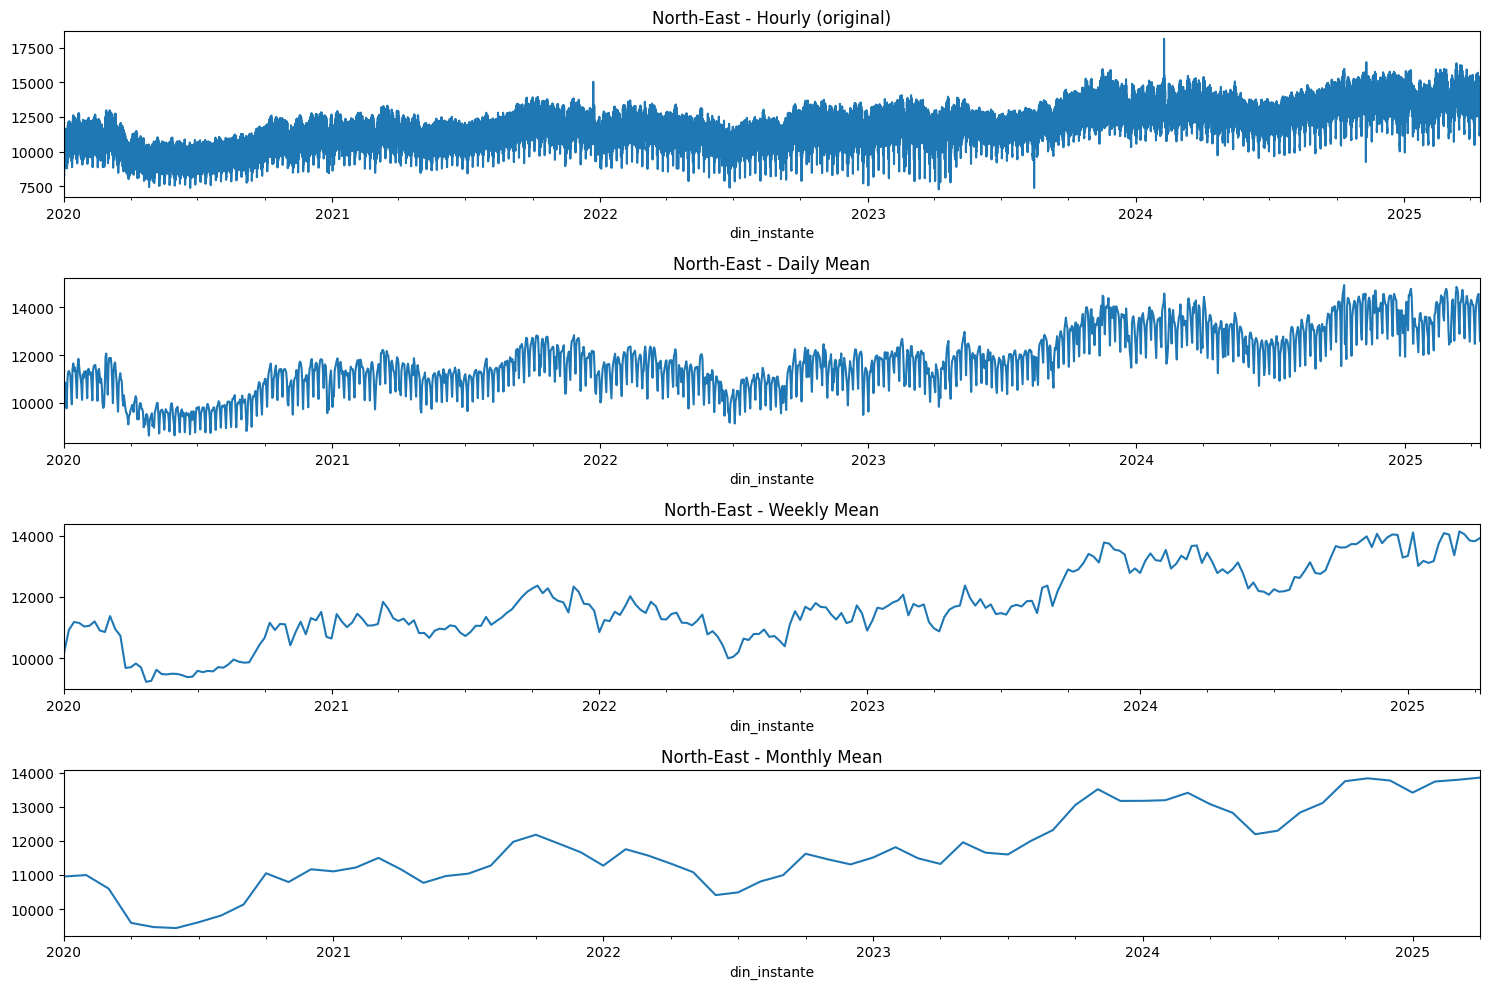

/tmp/ipython-input-3218227919.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  region['load'].resample('M').mean().plot(title=f"{name} - Monthly Mean")


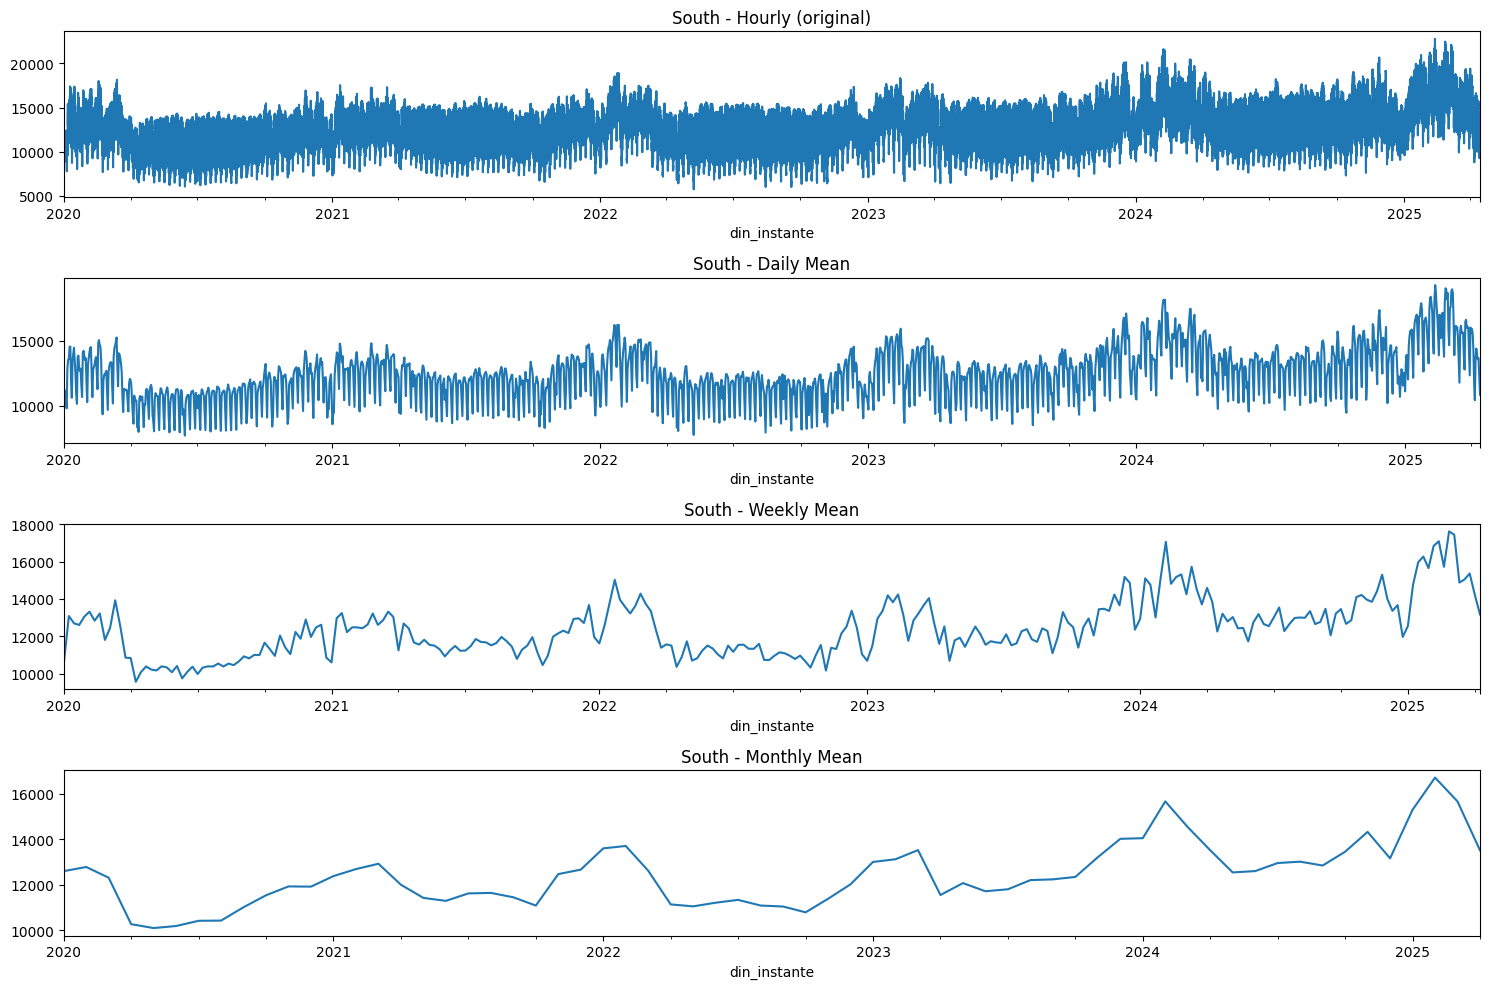

/tmp/ipython-input-3218227919.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  region['load'].resample('M').mean().plot(title=f"{name} - Monthly Mean")


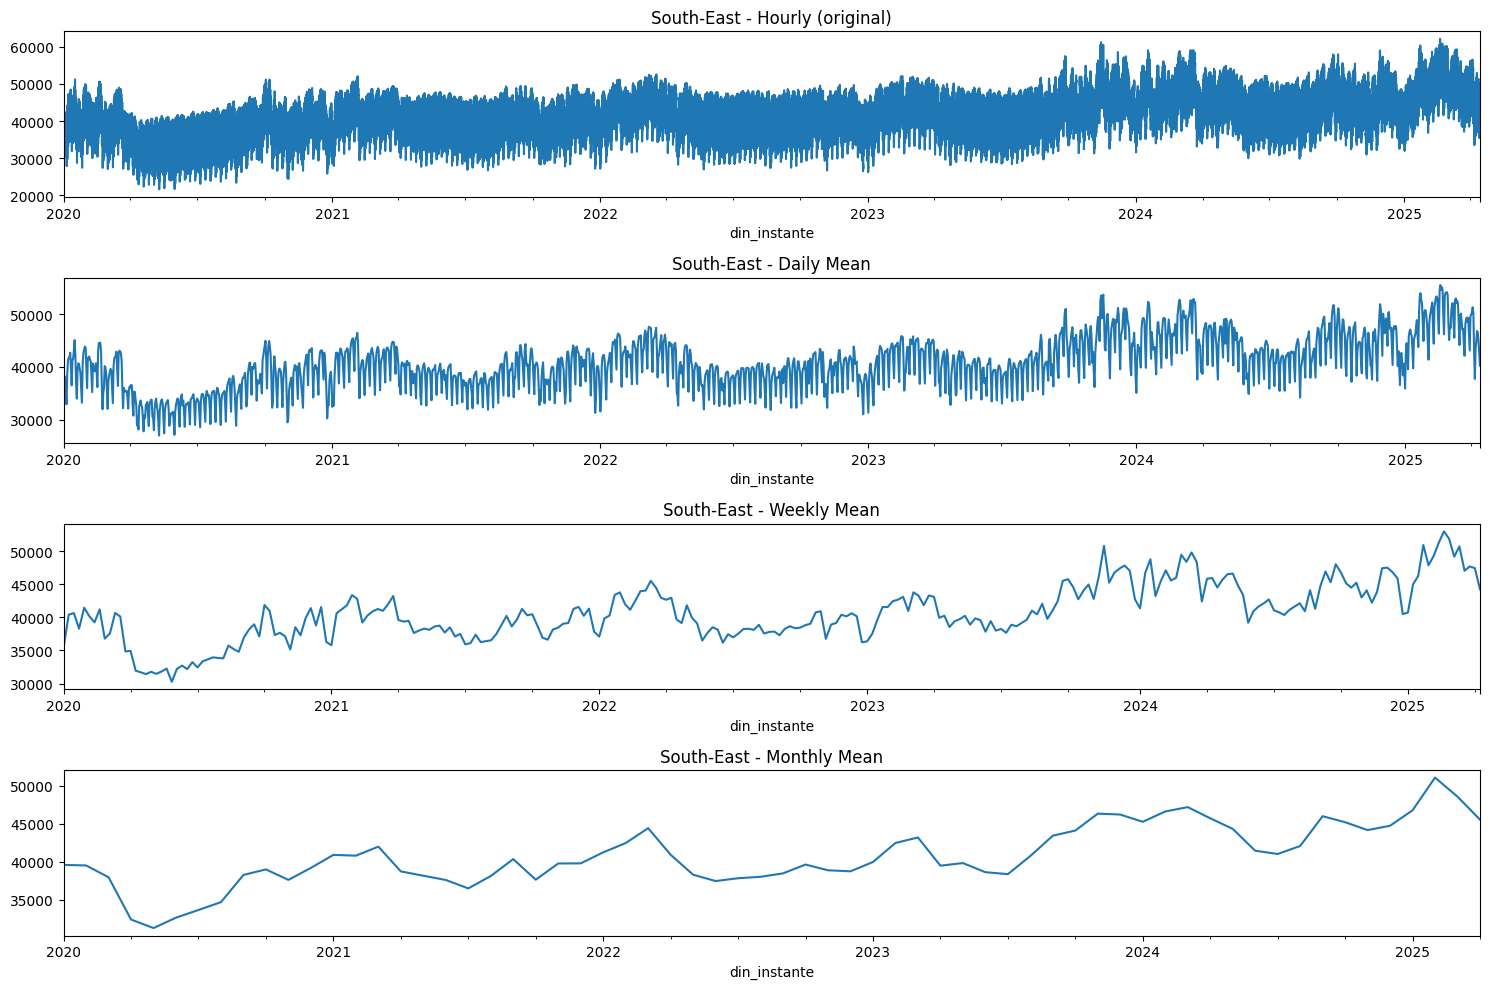

In [ ]:
def plot_resamples(region, name):
    plt.figure(figsize=(15, 10))

    # Original hourly
    plt.subplot(4,1,1)
    region['load'].plot(title=f"{name} - Hourly (original)")

    # Daily
    plt.subplot(4,1,2)
    region['load'].resample('D').mean().plot(title=f"{name} - Daily Mean")

    # Weekly
    plt.subplot(4,1,3)
    region['load'].resample('W').mean().plot(title=f"{name} - Weekly Mean")

    # Monthly
    plt.subplot(4,1,4)
    region['load'].resample('M').mean().plot(title=f"{name} - Monthly Mean")

    plt.tight_layout()
    plt.show()
plot_resamples(N, "North")
plot_resamples(NE, "North-East")
plot_resamples(S, "South")
plot_resamples(SE, "South-East")


/tmp/ipython-input-3285608967.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = region_df['load'].resample('M').mean()


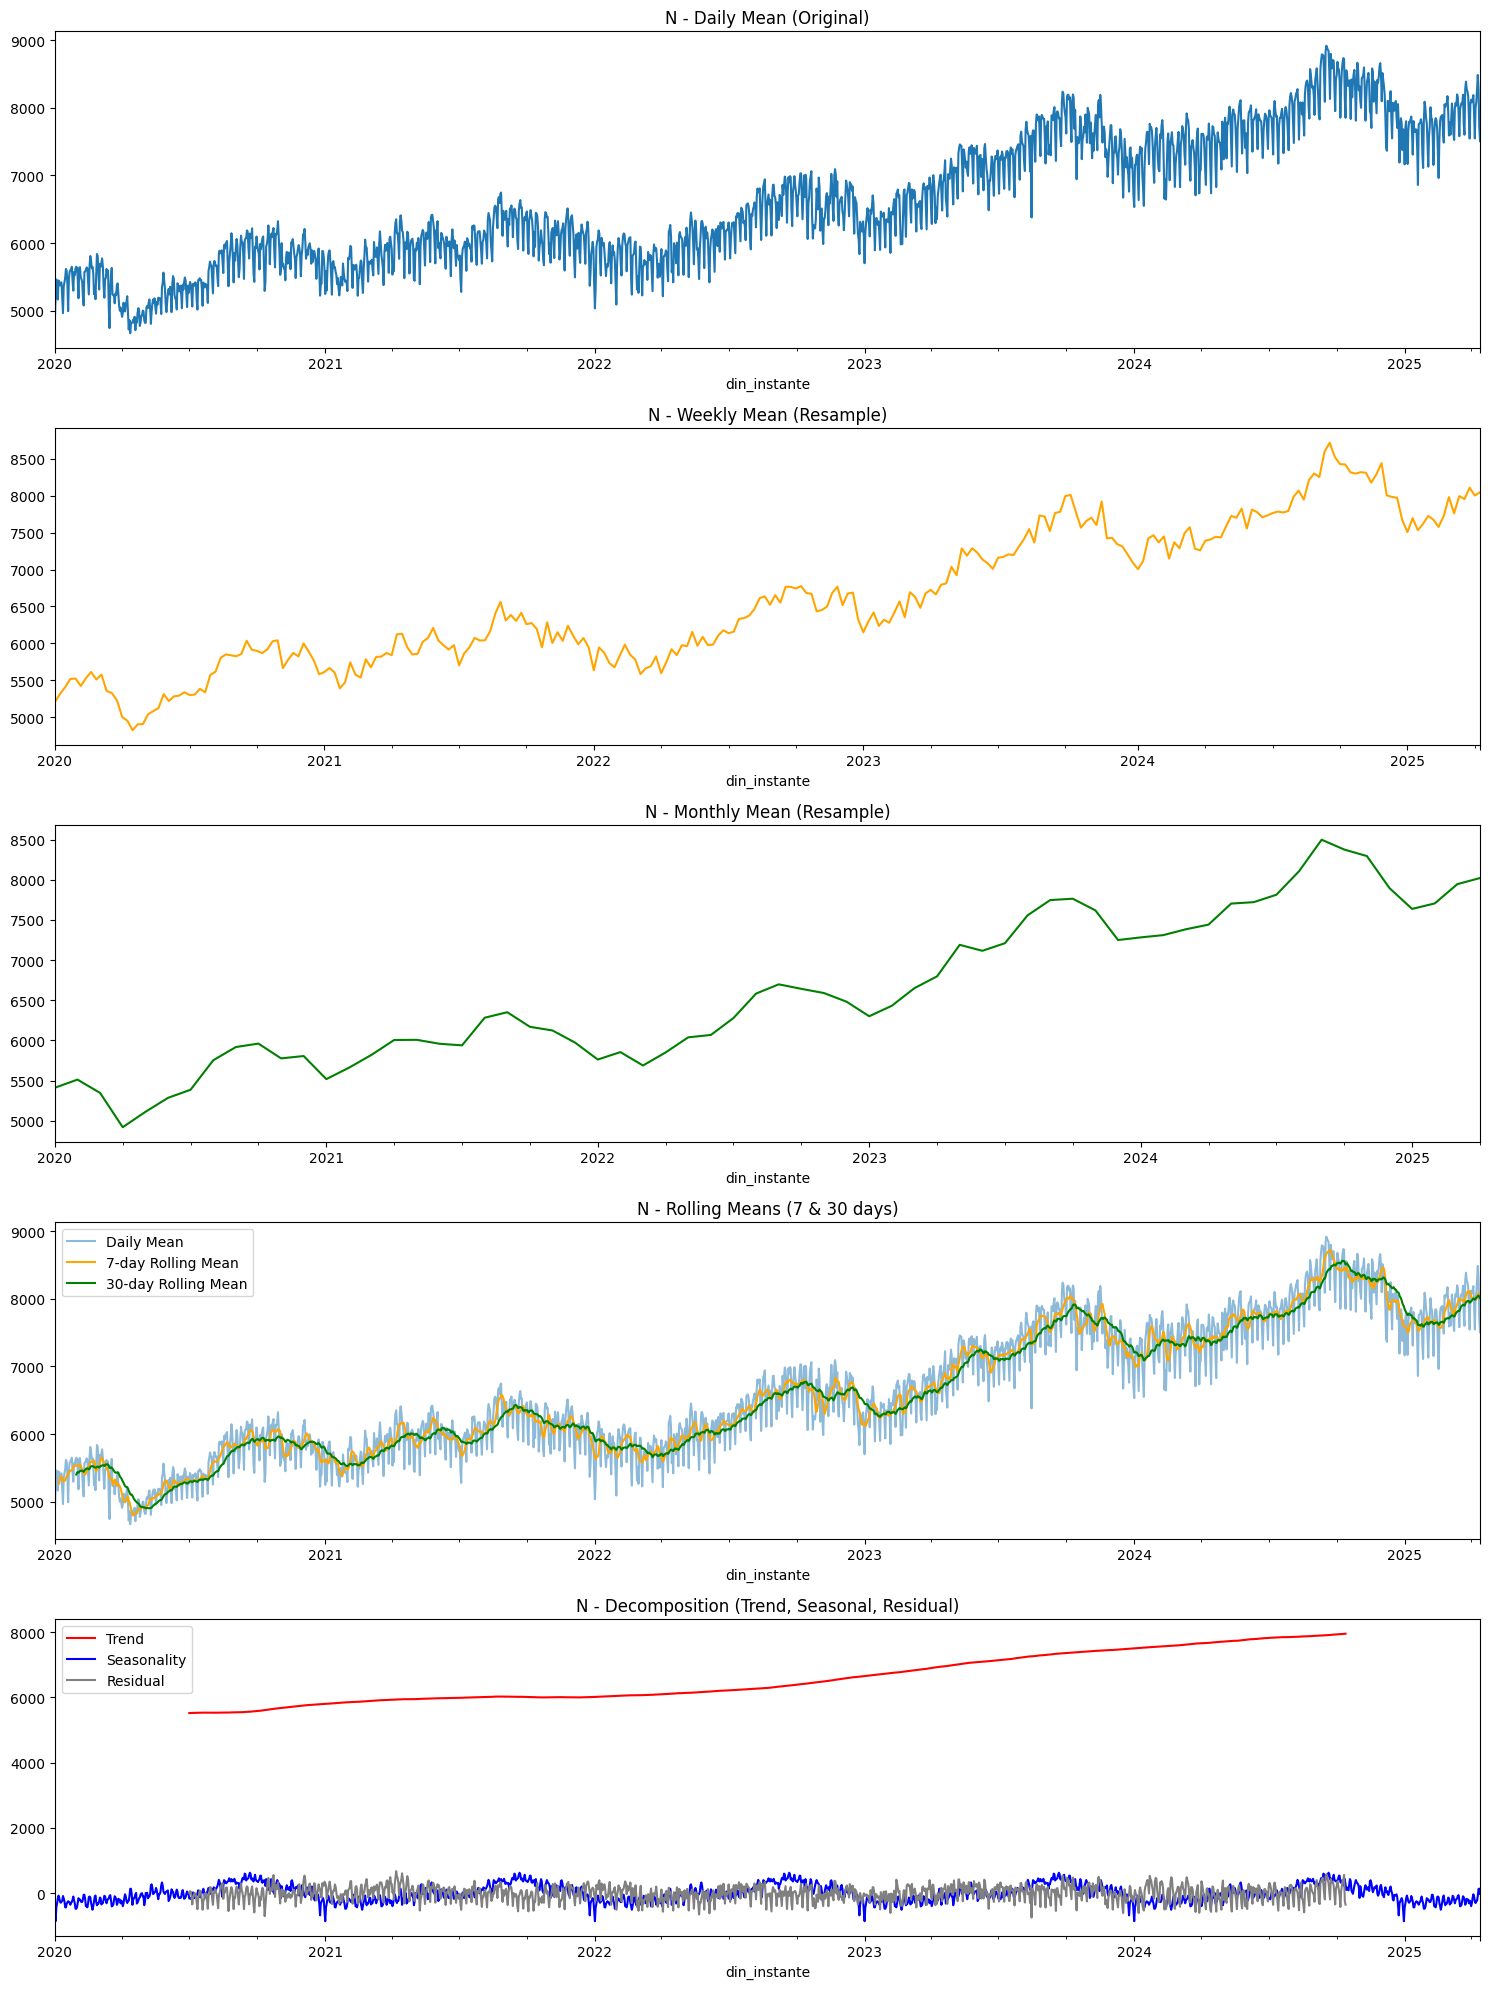

--- N Region Analysis ---


/tmp/ipython-input-3285608967.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = region_df['load'].resample('M').mean()


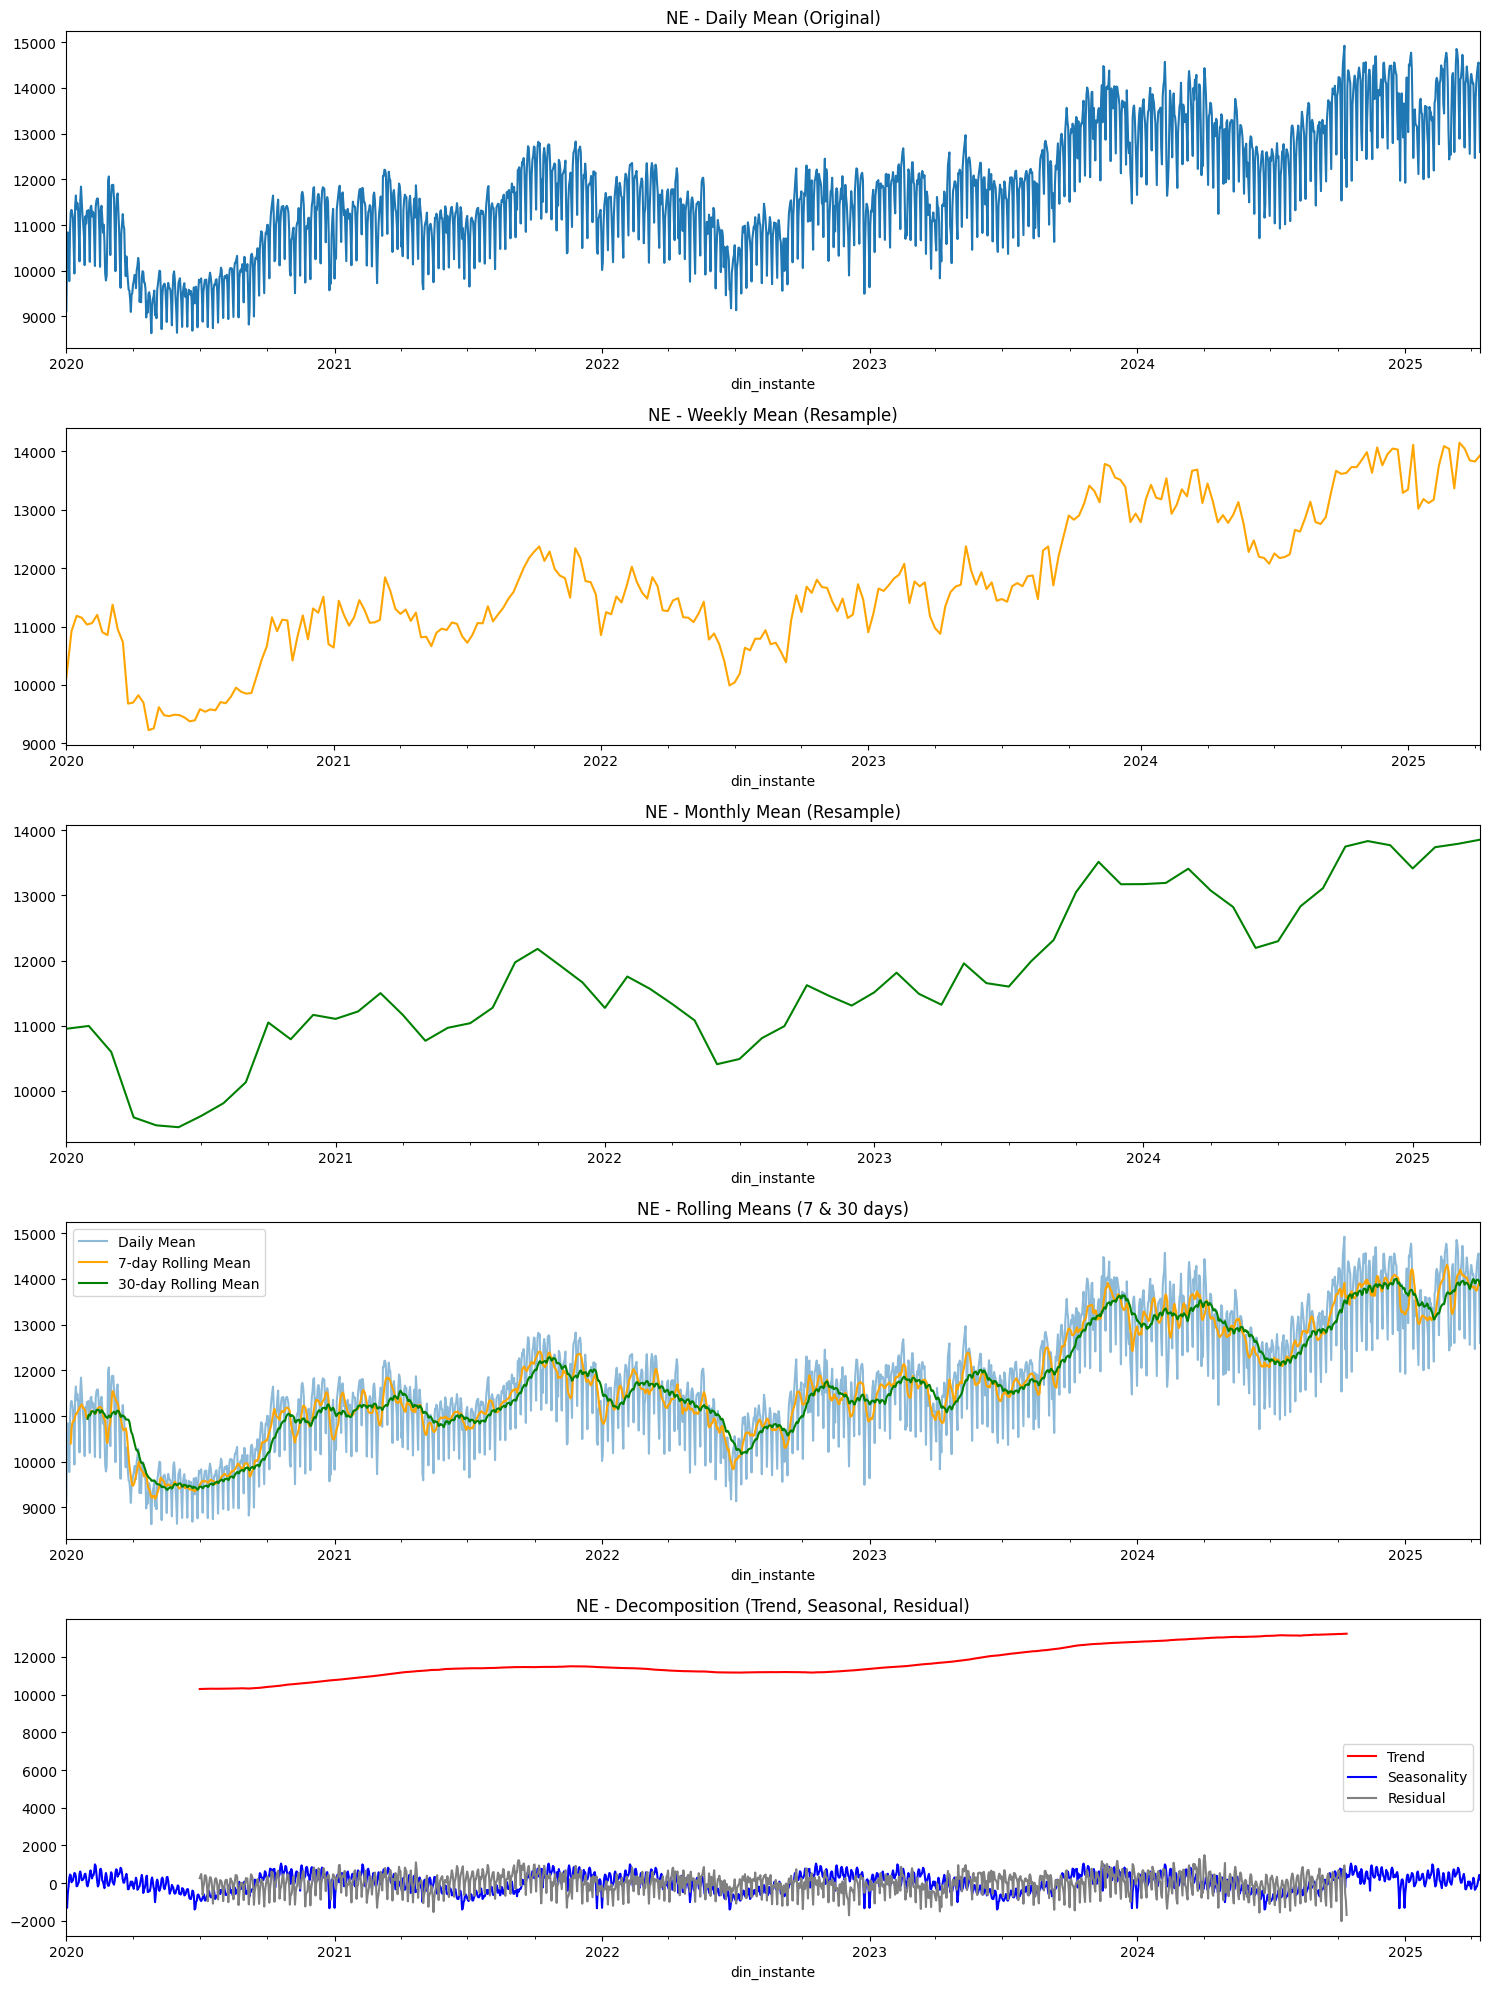

--- NE Region Analysis ---


/tmp/ipython-input-3285608967.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = region_df['load'].resample('M').mean()


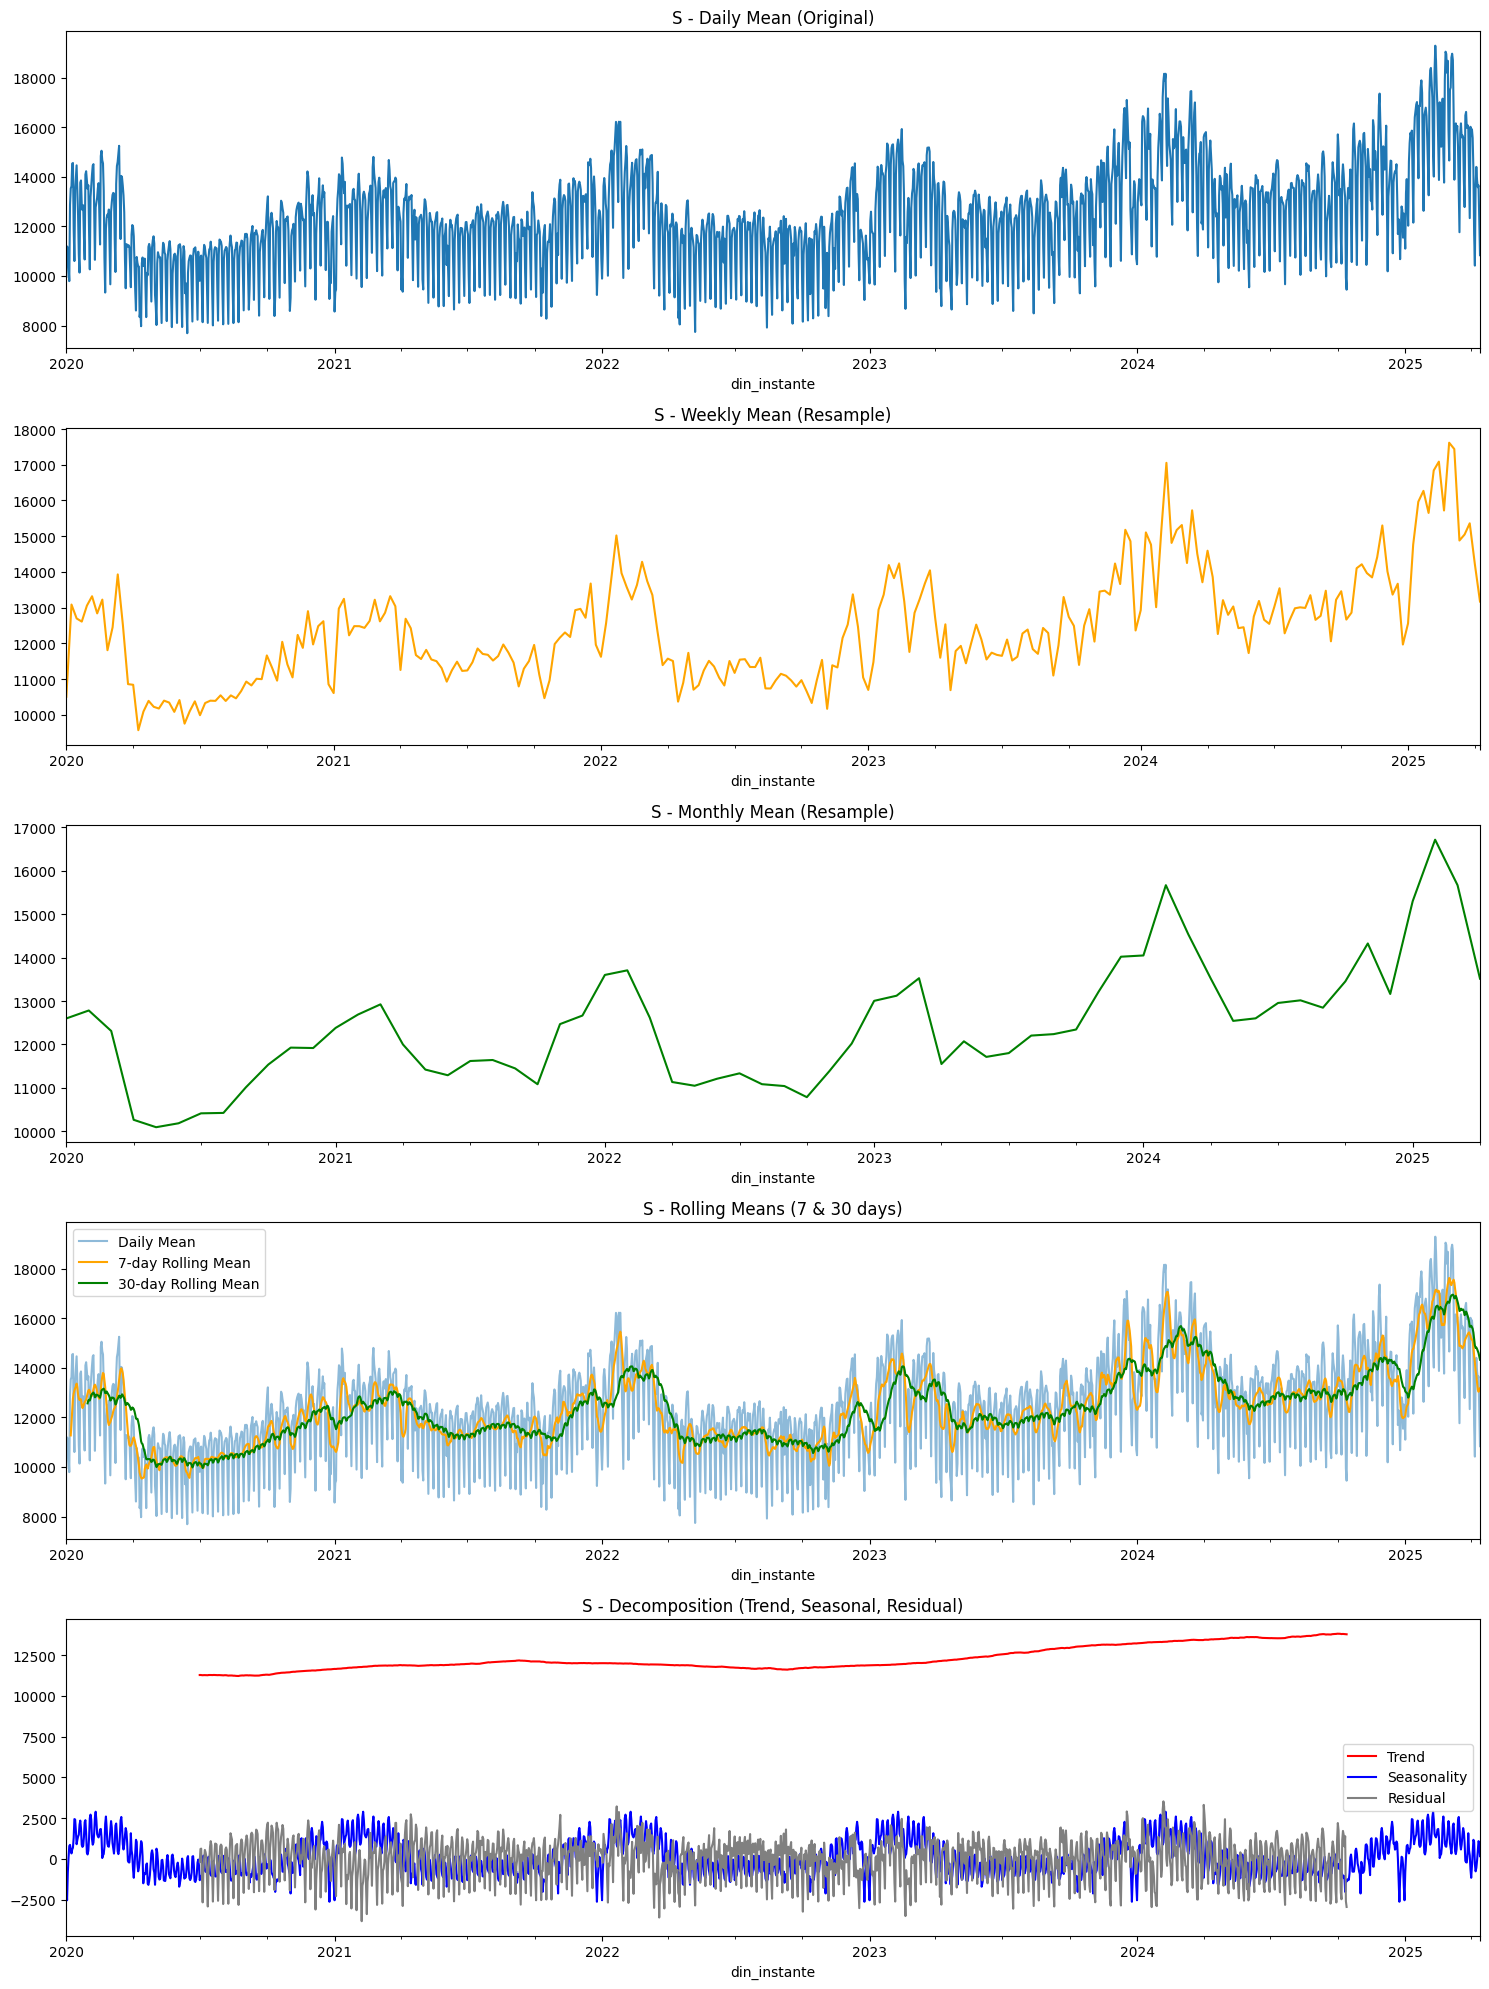

--- S Region Analysis ---


/tmp/ipython-input-3285608967.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = region_df['load'].resample('M').mean()


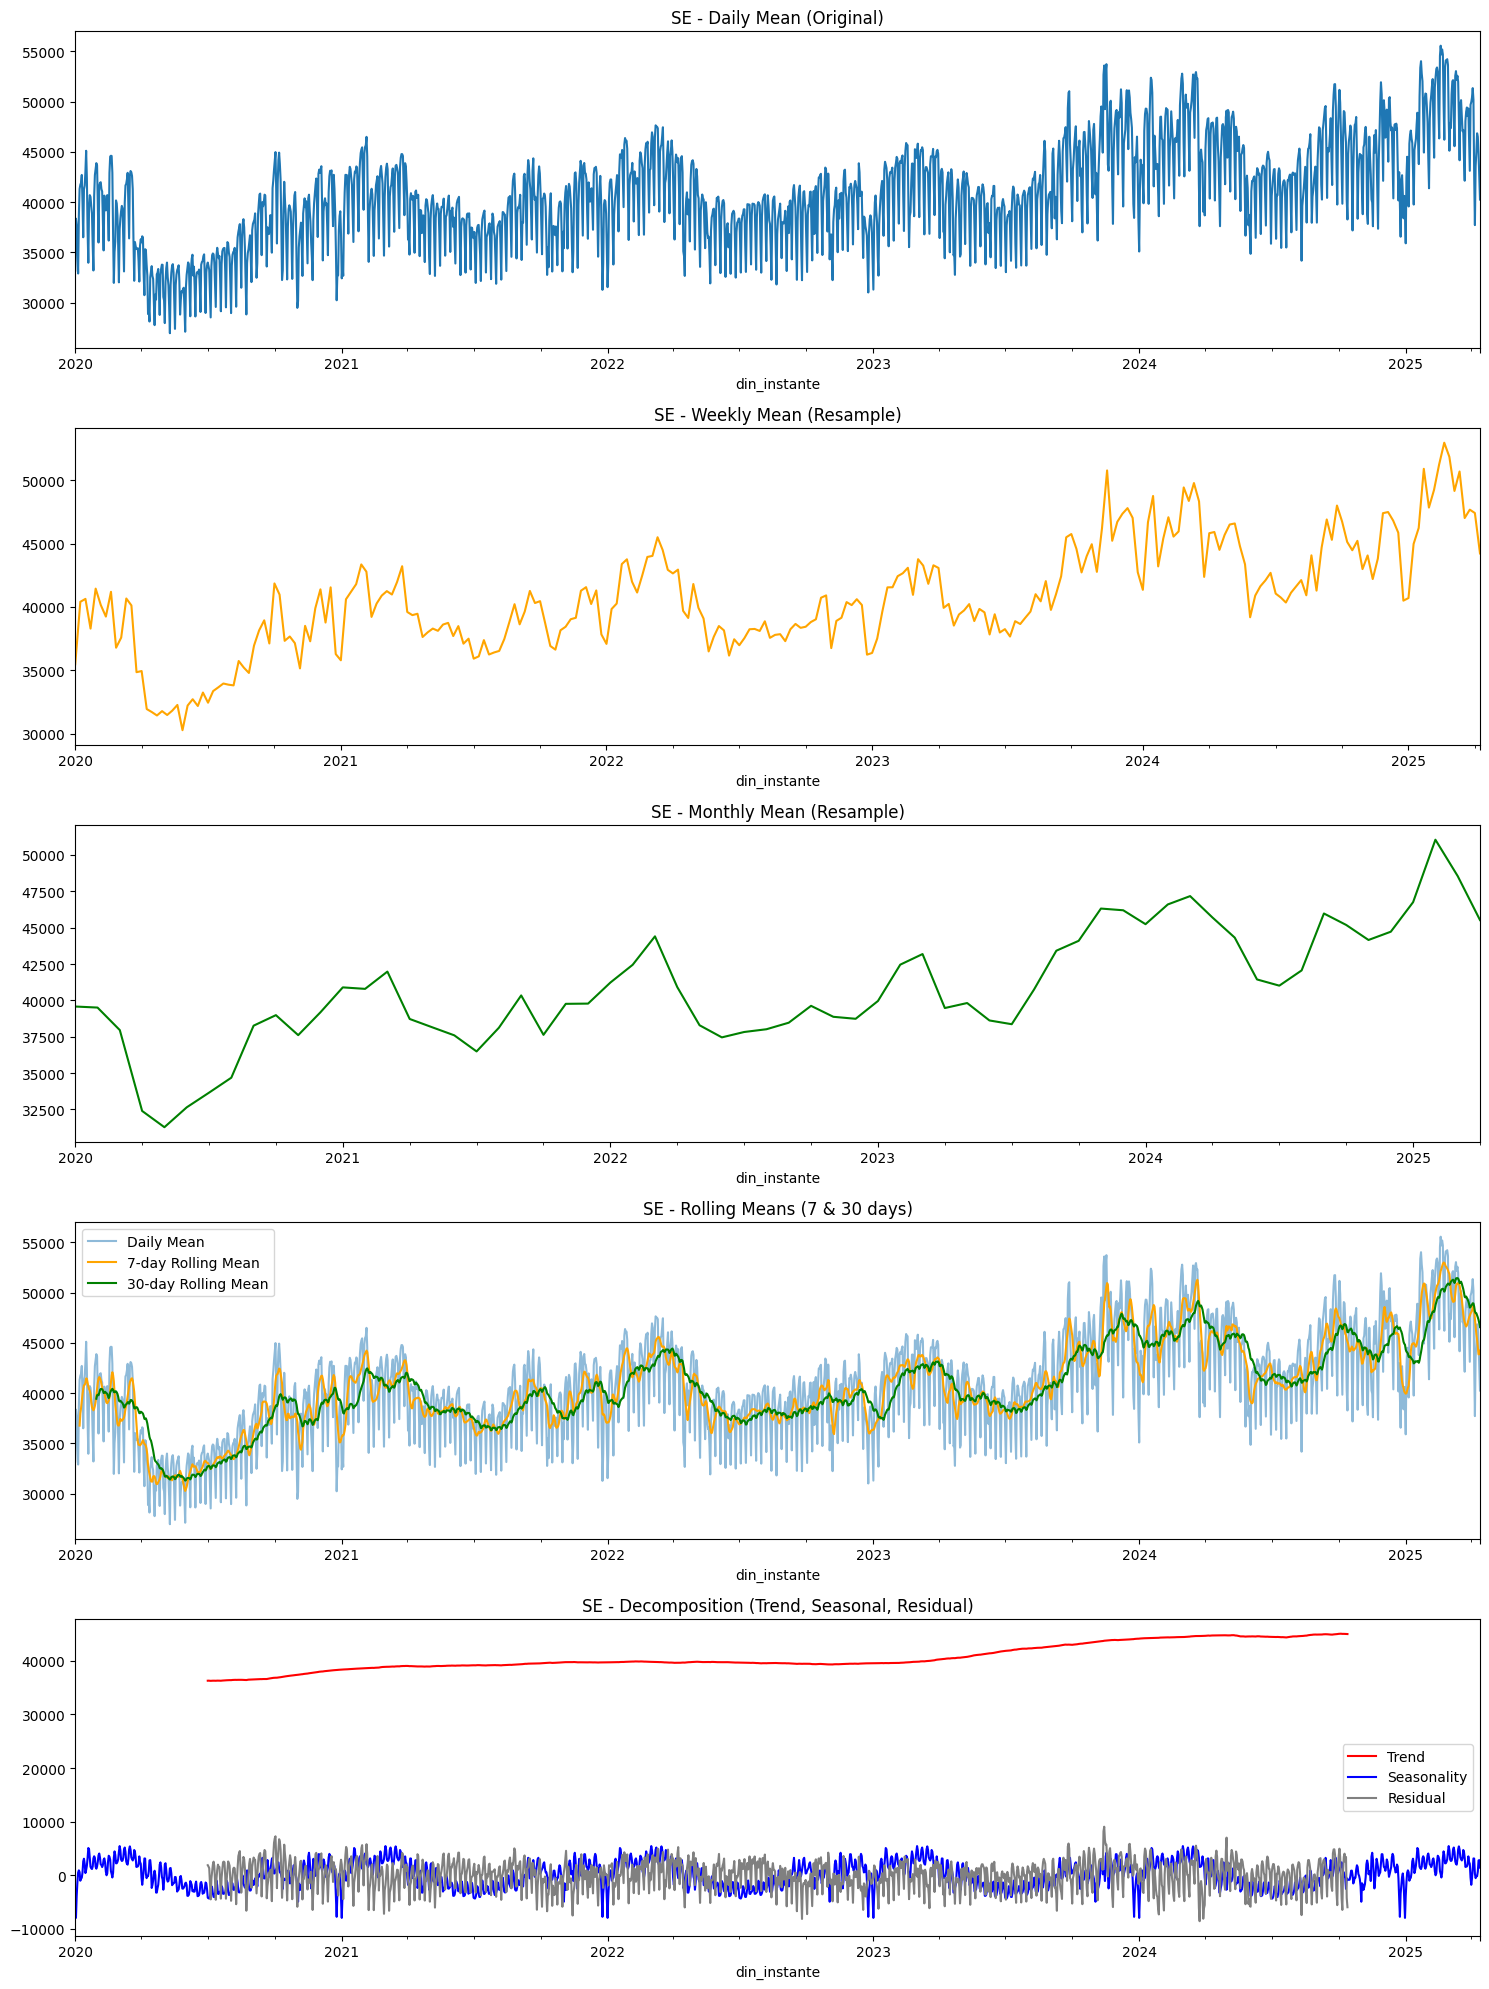

--- SE Region Analysis ---


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


Regions = {'N': N, 'NE': NE, 'S': S, 'SE': SE}

def analyze_region(region_df, region_name):
    plt.figure(figsize=(15, 20))

    daily = region_df['load'].resample('D').mean()
    plt.subplot(5,1,1)
    daily.plot(title=f"{region_name} - Daily Mean (Original)")

    weekly = region_df['load'].resample('W').mean()
    monthly = region_df['load'].resample('M').mean()

    plt.subplot(5,1,2)
    weekly.plot(title=f"{region_name} - Weekly Mean (Resample)", color='orange')

    plt.subplot(5,1,3)
    monthly.plot(title=f"{region_name} - Monthly Mean (Resample)", color='green')


    rolling7 = daily.rolling(window=7).mean()
    rolling30 = daily.rolling(window=30).mean()
    rolling7_std = daily.rolling(window=7).std()

    plt.subplot(5,1,4)
    daily.plot(label='Daily Mean', alpha=0.5)
    rolling7.plot(label='7-day Rolling Mean', color='orange')
    rolling30.plot(label='30-day Rolling Mean', color='green')
    plt.legend()
    plt.title(f"{region_name} - Rolling Means (7 & 30 days)")


    decomposition = seasonal_decompose(daily.interpolate(), model='additive', period=365)

    plt.subplot(5,1,5)
    decomposition.trend.plot(label='Trend', color='red')
    decomposition.seasonal.plot(label='Seasonality', color='blue')
    decomposition.resid.plot(label='Residual', color='gray')
    plt.legend()
    plt.title(f"{region_name} - Decomposition (Trend, Seasonal, Residual)")

    plt.tight_layout()
    plt.show()


    print(f"--- {region_name} Region Analysis ---")



for name, df in Regions.items():
    analyze_region(df, name)


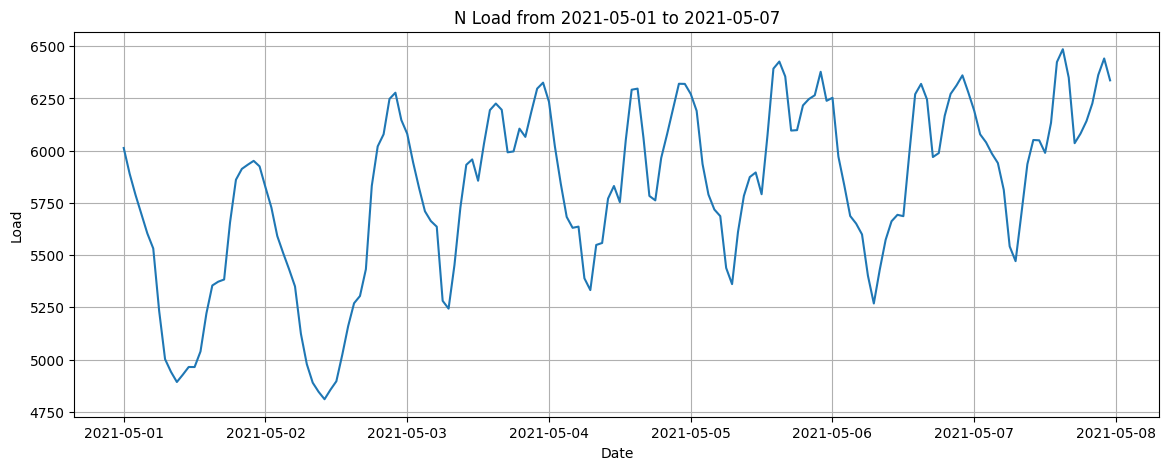

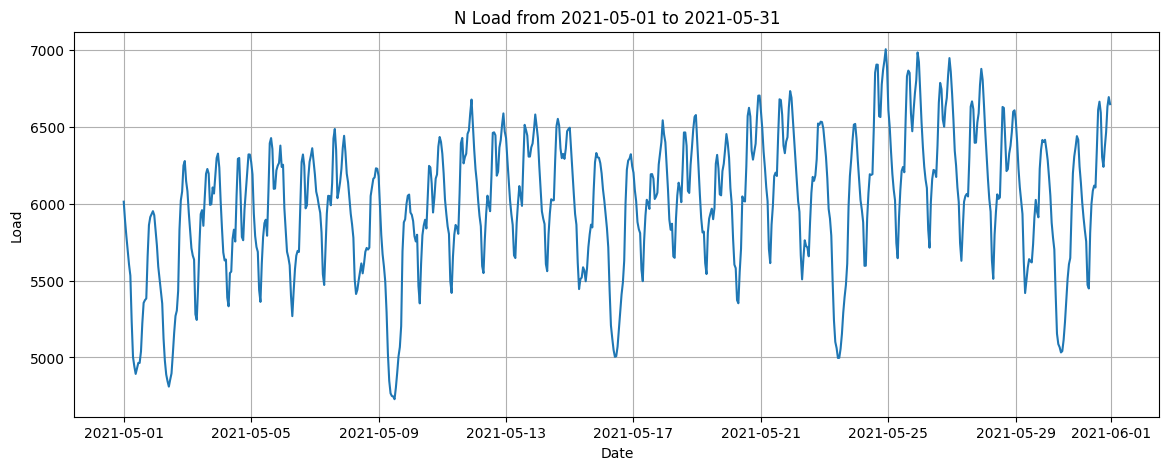

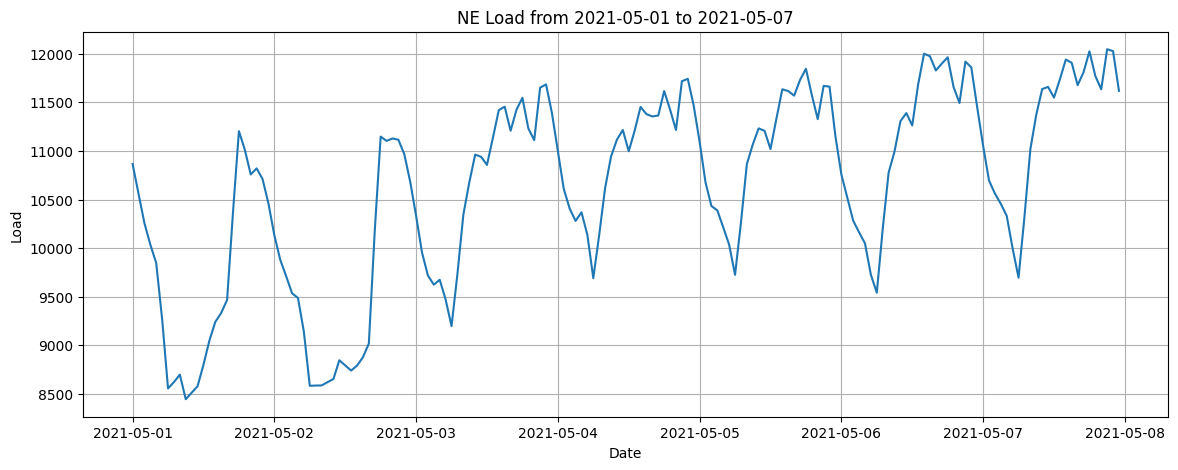

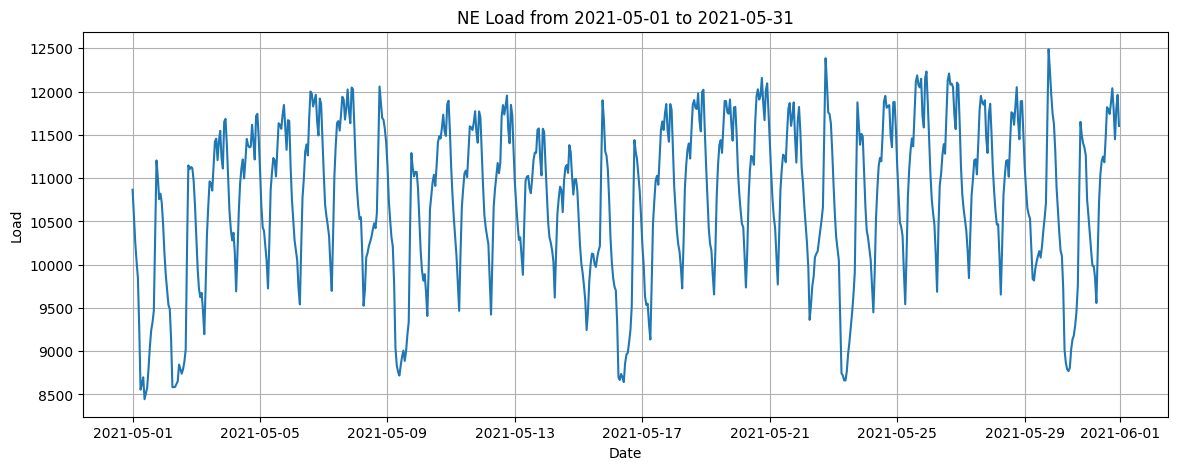

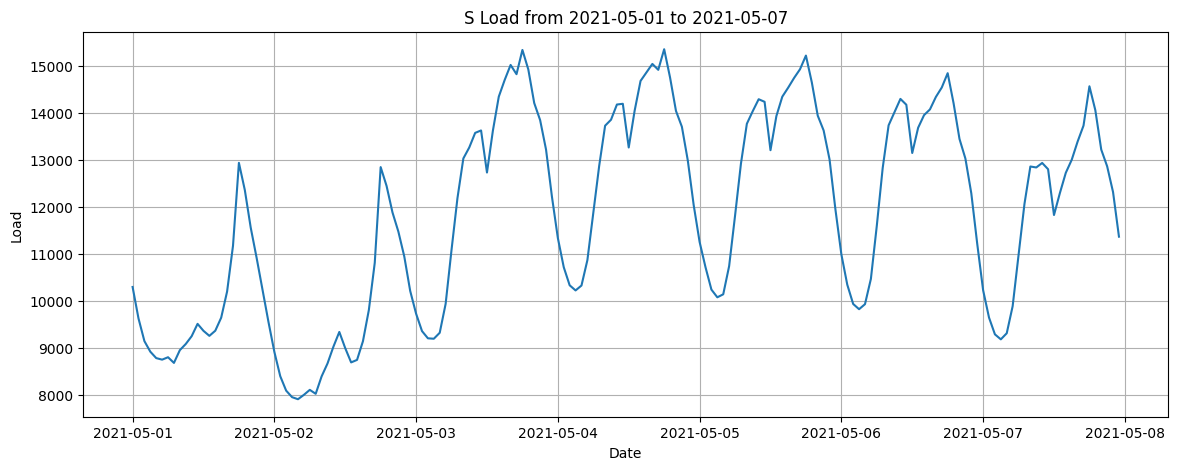

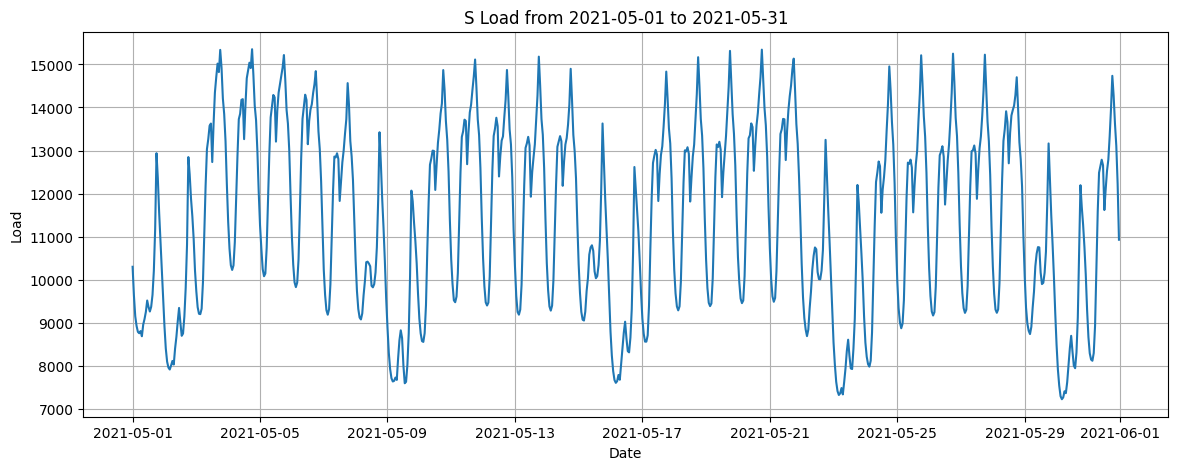

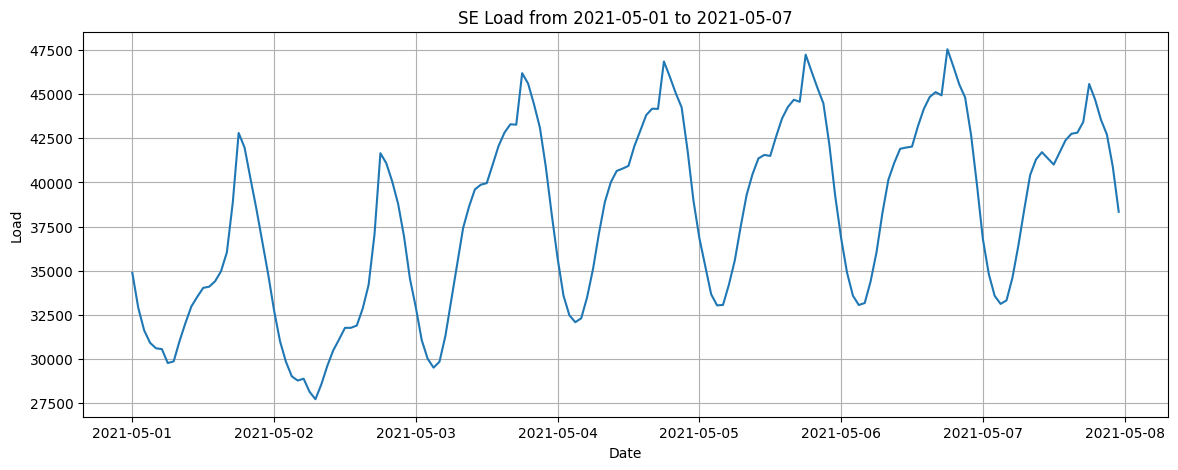

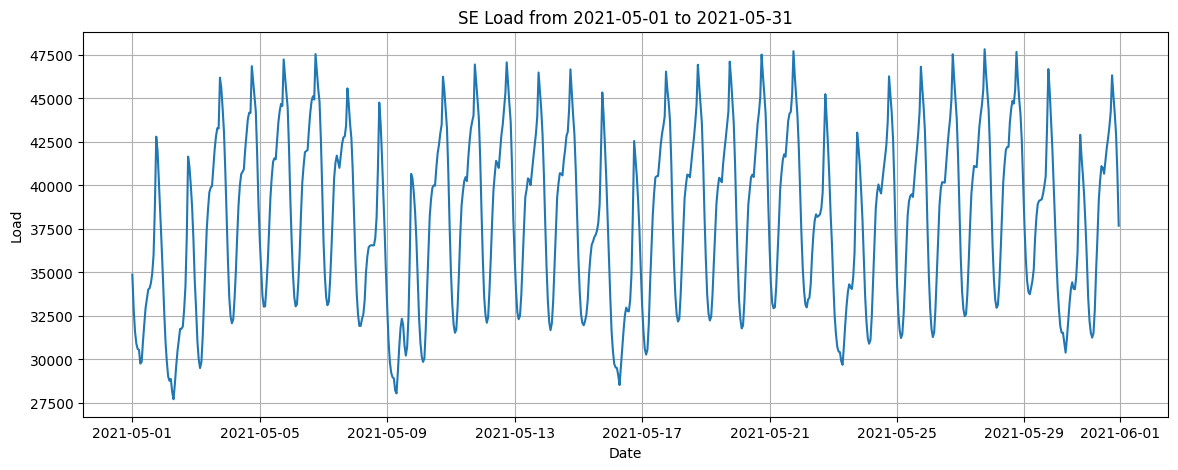

In [ ]:
def plot_zoom(region_df, region_name, start, end):
    # cut the period
    zoom = region_df.loc[start:end]

    plt.figure(figsize=(14,5))
    plt.plot(zoom.index, zoom['load'])
    plt.title(f"{region_name} Load from {start} to {end}")
    plt.xlabel("Date")
    plt.ylabel("Load")
    plt.grid(True)
    plt.show()


plot_zoom(N, "N", "2021-05-01", "2021-05-07")


plot_zoom(N, "N", "2021-05-01", "2021-05-31")

plot_zoom(NE, "NE", "2021-05-01", "2021-05-07")


plot_zoom(NE, "NE", "2021-05-01", "2021-05-31")

plot_zoom(S, "S", "2021-05-01", "2021-05-07")


plot_zoom(S, "S", "2021-05-01", "2021-05-31")

plot_zoom(SE, "SE", "2021-05-01", "2021-05-07")


plot_zoom(SE, "SE", "2021-05-01", "2021-05-31")




In [ ]:
dates = pd.date_range("2021-05-01", "2021-05-07", freq="D")
for d in dates:
    print(d.date(), d.day_name())

2021-05-01 Saturday
2021-05-02 Sunday
2021-05-03 Monday
2021-05-04 Tuesday
2021-05-05 Wednesday
2021-05-06 Thursday
2021-05-07 Friday


# From the zoomed-in plot:
# Daily Seasonality (24-hour cycle) The load follows a consistent pattern every day.

#Peaks and troughs repeat at almost the same hours.

This confirms the presence of strong daily seasonality, meaning the value at hour t is heavily influenced by the value at hour t-24
#Weekly Effect (Weekend Drop)
bold text
By checking the calendar, 2021-05-01 and 2021-05-02 correspond to Saturday and Sunday.

Both days show a noticeable drop in overall load levels, even though the daily pattern shape remains.

In [ ]:
full_range = pd.date_range(start=N.index.min(), end=N.index.max(), freq='H')
missing = full_range.difference(N.index)
missing[:10]

/tmp/ipython-input-93516167.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=N.index.min(), end=N.index.max(), freq='H')


DatetimeIndex([], dtype='datetime64[ns]', freq='h')

no missing **timestamps**

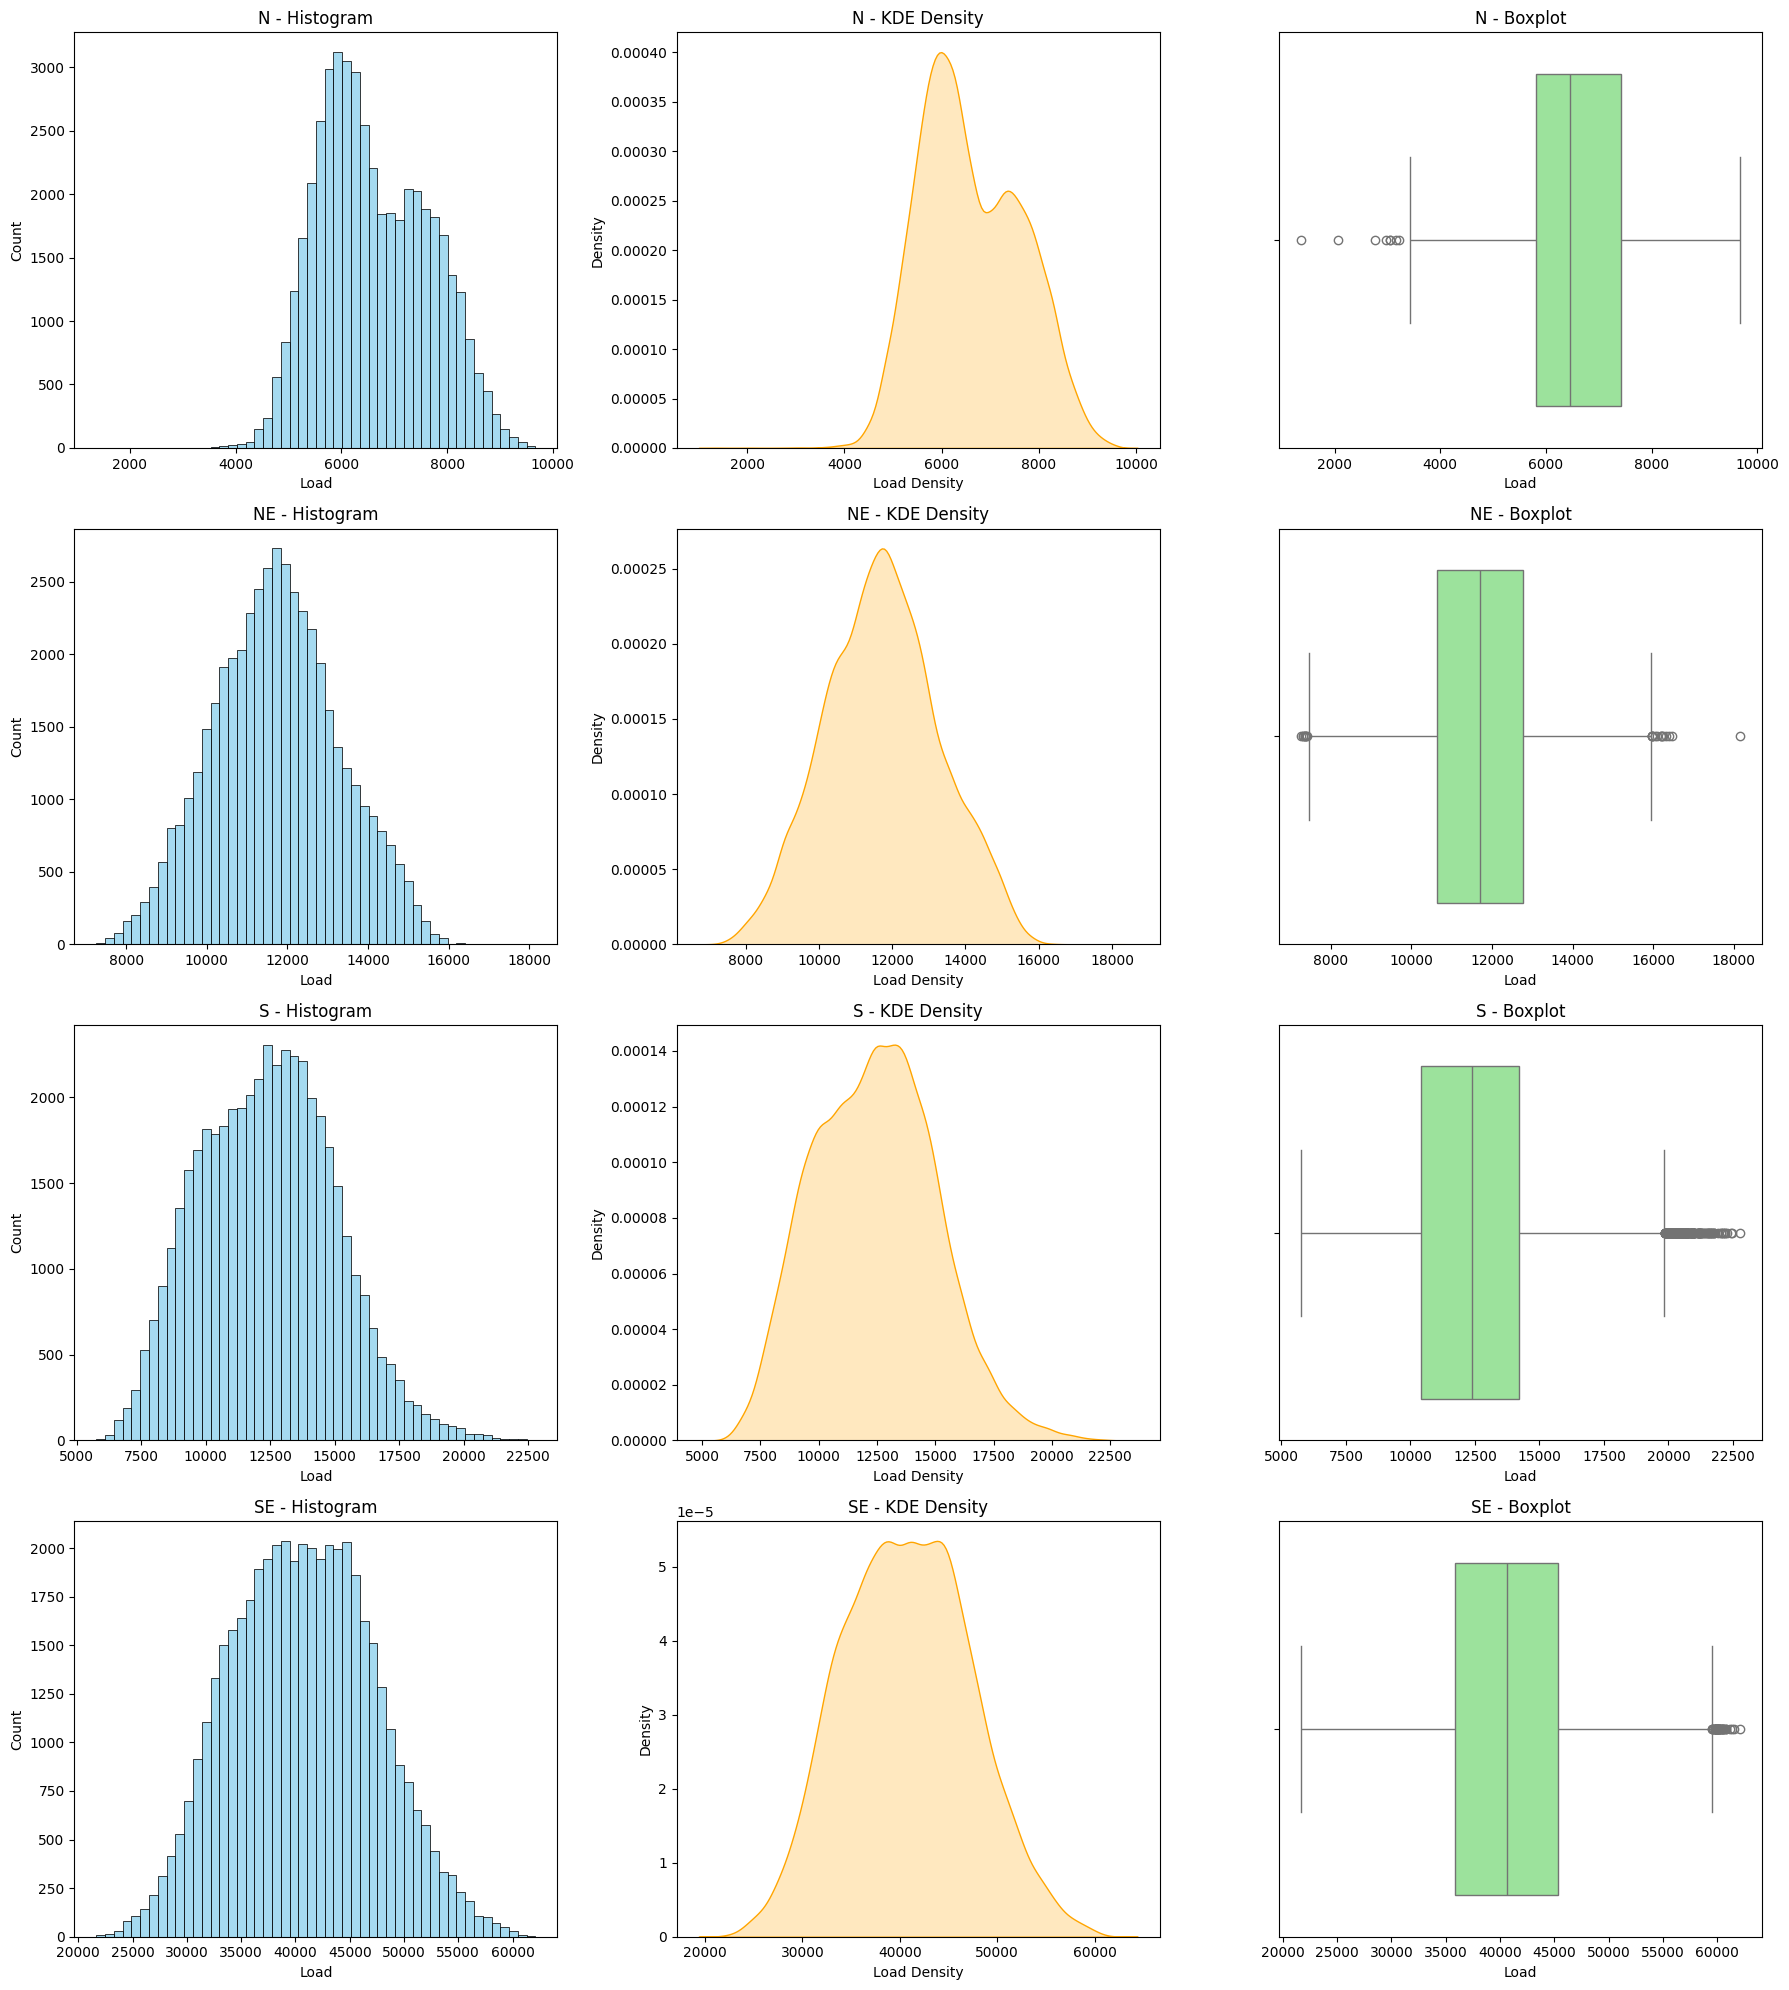

In [ ]:
def plot_distribution_for_regions(Regions):
    plt.figure(figsize=(18, 20))
    idx = 1

    for name, df in Regions.items():


        plt.subplot(4, 3, idx)
        sns.histplot(df['load'], bins=50, kde=False, color='skyblue')
        plt.title(f"{name} - Histogram")
        plt.xlabel("Load")
        plt.ylabel("Count")
        idx += 1


        plt.subplot(4, 3, idx)
        sns.kdeplot(df['load'], fill=True, color='orange')
        plt.title(f"{name} - KDE Density")
        plt.xlabel("Load Density")
        idx += 1


        plt.subplot(4, 3, idx)
        sns.boxplot(x=df['load'], color='lightgreen')
        plt.title(f"{name} - Boxplot")
        plt.xlabel("Load")
        idx += 1

    plt.tight_layout()
    plt.show()



plot_distribution_for_regions(Regions)

normal-like distribution 'all 4 regions'
but their difference in scale and width some regions with tigher distribution and some with wider

# **Feature Engineering**

In [ ]:
def drop_unnecessary_columns():
    for i in Regions:
        Regions[i] = Regions[i].drop(['id_subsistema','nom_subsistema'], axis=1,inplace=True)

drop_unnecessary_columns()


In [ ]:
def time_series_split(df, test_size=0.1, val_size=0.1):

    n = len(df)

    test_point = int(n * (1 - test_size))
    val_point = int(test_point * (1 - val_size))

    train = df.iloc[:val_point]
    val = df.iloc[val_point:test_point]
    test = df.iloc[test_point:]

    return train, val, test
N_train, N_val, N_test = time_series_split(N)
NE_train, NE_val, NE_test = time_series_split(NE)
S_train, S_val, S_test = time_series_split(S)
SE_train, SE_val, SE_test = time_series_split(SE)


In [ ]:
def create_features(df):
    df = df.copy()


    for lag in [1, 24, 48, 72, 168, 336, 720]:
        df[f'lag_{lag}'] = df['load'].shift(lag)


    df['roll_24'] = df['load'].shift(1).rolling(24).mean()
    df['roll_24_std'] = df['load'].shift(1).rolling(24).std()
    df['std_168'] = df['load'].shift(1).rolling(168).std()
    df['roll_168'] = df['load'].shift(1).rolling(168).mean()
    df['roll_336'] = df['load'].shift(1).rolling(336).mean()
    df['roll_720'] = df['load'].shift(1).rolling(720).mean()

    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['weekday'] = df.index.weekday
    df['month'] = df.index.month
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)


    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)


    df = df.dropna()

    return df


In [ ]:
history = 720


Regions_split = {
    'N': (N_train, N_val, N_test),
    'NE': (NE_train, NE_val, NE_test),
    'S': (S_train, S_val, S_test),
    'SE': (SE_train, SE_val, SE_test)
}

for name, (train, val, test) in Regions_split.items():
    # Train
    train_f = create_features(train)


    val_history = pd.concat([train.tail(history), val])
    val_f = create_features(val_history).iloc[history:]


    test_history = pd.concat([train.tail(history), val.tail(history), test])
    test_f = create_features(test_history).iloc[-len(test):]


    Regions_split[name] = {
        'train': train_f,
        'val': val_f,
        'test': test_f
    }


N_train = Regions_split['N']['train']
N_val   = Regions_split['N']['val']
N_test  = Regions_split['N']['test']

NE_train = Regions_split['NE']['train']
NE_val   = Regions_split['NE']['val']
NE_test  = Regions_split['NE']['test']

S_train = Regions_split['S']['train']
S_val   = Regions_split['S']['val']
S_test  = Regions_split['S']['test']

SE_train = Regions_split['SE']['train']
SE_val   = Regions_split['SE']['val']
SE_test  = Regions_split['SE']['test']



In [ ]:
target_col = 'load'


X_train_N = N_train.drop(columns=[target_col])
y_train_N = N_train[target_col]

X_val_N = N_val.drop(columns=[target_col])
y_val_N = N_val[target_col]

X_test_N = N_test.drop(columns=[target_col])
y_test_N = N_test[target_col]


X_train_NE = NE_train.drop(columns=[target_col])
y_train_NE = NE_train[target_col]

X_val_NE = NE_val.drop(columns=[target_col])
y_val_NE = NE_val[target_col]

X_test_NE = NE_test.drop(columns=[target_col])
y_test_NE = NE_test[target_col]

X_train_S = S_train.drop(columns=[target_col])
y_train_S = S_train[target_col]

X_val_S = S_val.drop(columns=[target_col])
y_val_S = S_val[target_col]

X_test_S = S_test.drop(columns=[target_col])
y_test_S = S_test[target_col]


X_train_SE = SE_train.drop(columns=[target_col])
y_train_SE = SE_train[target_col]

X_val_SE = SE_val.drop(columns=[target_col])
y_val_SE = SE_val[target_col]

X_test_SE = SE_test.drop(columns=[target_col])
y_test_SE = SE_test[target_col]
target_col = 'load'

Regions_split_final = {
    'N':  {'X_train': X_train_N,  'y_train': y_train_N,
           'X_val': X_val_N,      'y_val': y_val_N,
           'X_test': X_test_N,    'y_test': y_test_N},

    'NE': {'X_train': X_train_NE, 'y_train': y_train_NE,
           'X_val': X_val_NE,     'y_val': y_val_NE,
           'X_test': X_test_NE,   'y_test': y_test_NE},

    'S':  {'X_train': X_train_S,  'y_train': y_train_S,
           'X_val': X_val_S,      'y_val': y_val_S,
           'X_test': X_test_S,    'y_test': y_test_S},

    'SE': {'X_train': X_train_SE, 'y_train': y_train_SE,
           'X_val': X_val_SE,     'y_val': y_val_SE,
           'X_test': X_test_SE,   'y_test': y_test_SE}
}



In [ ]:


def plot_predictions(region, y_true, y_pred):
    plt.figure(figsize=(12,4))
    plt.plot(y_true.values, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f'Actual vs Predicted - Region {region}')
    plt.legend()
    plt.show()



=== Region N ===
Train RMSE: 65.80
Val RMSE:   175.94
Test RMSE:  152.97


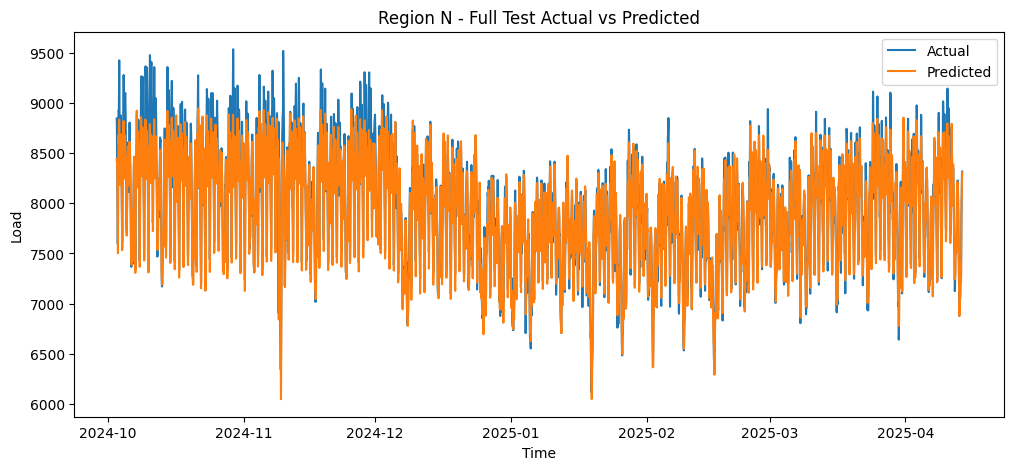

MAE Last 24h: 63.31


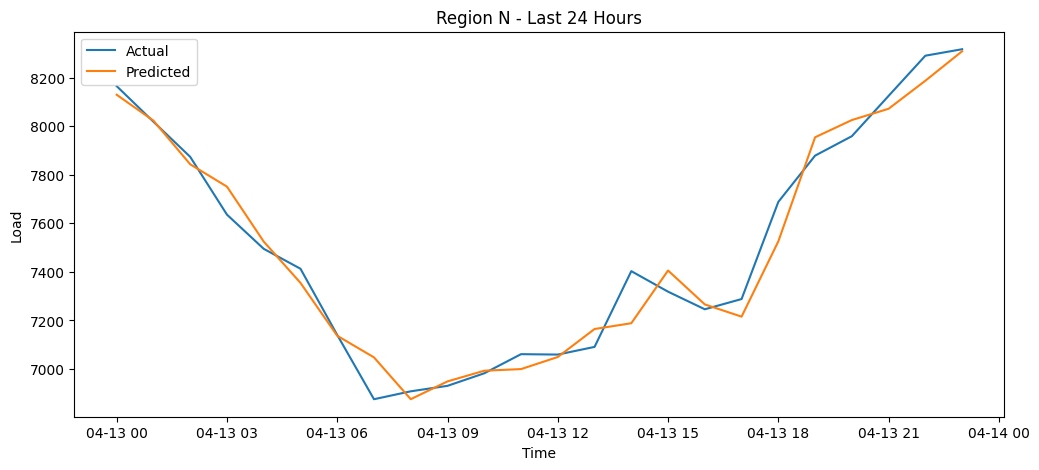

MAE Last 168h: 100.44


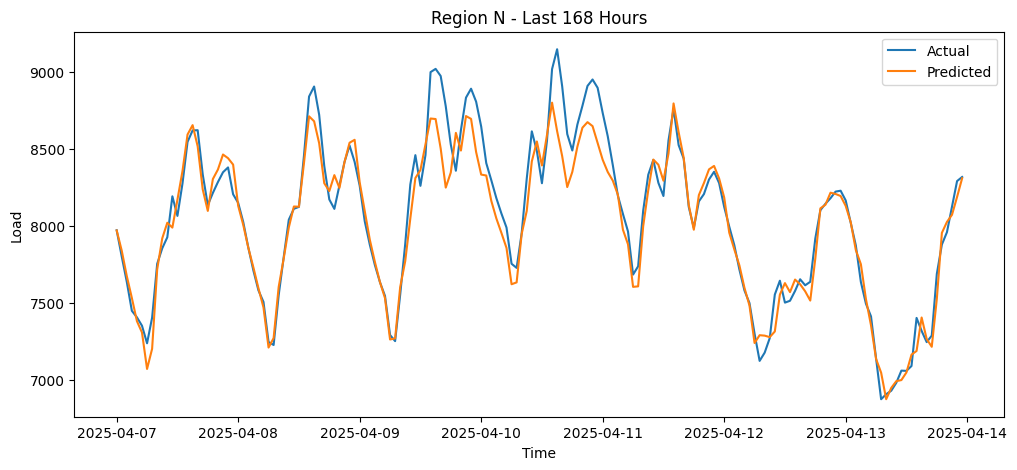


=== Region NE ===
Train RMSE: 81.07
Val RMSE:   157.18
Test RMSE:  255.88


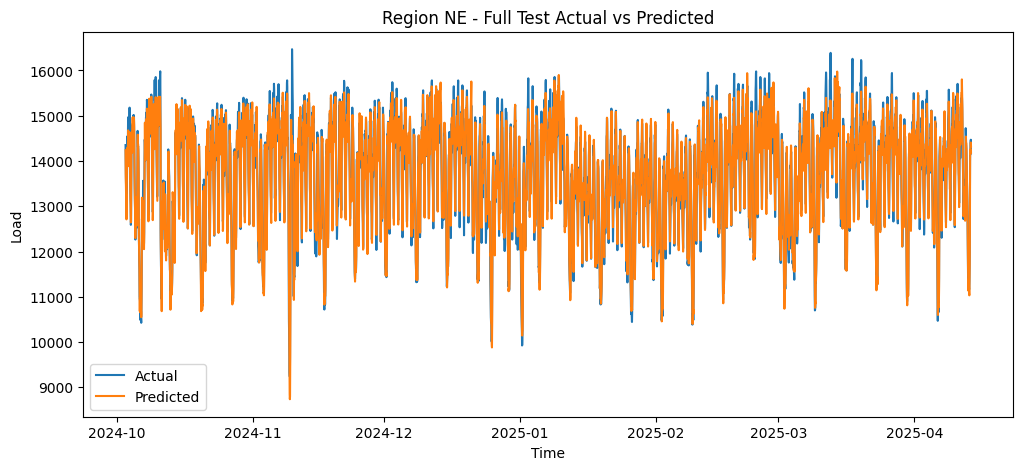

MAE Last 24h: 146.49


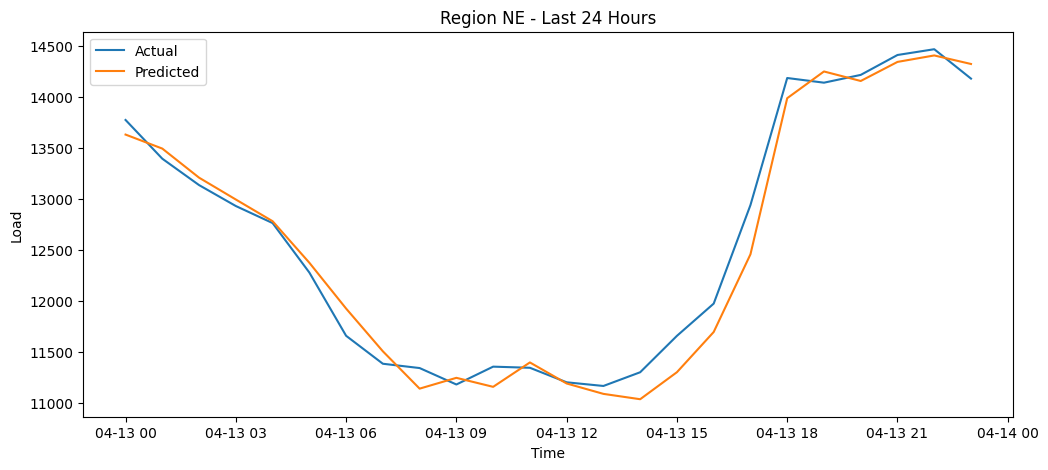

MAE Last 168h: 164.65


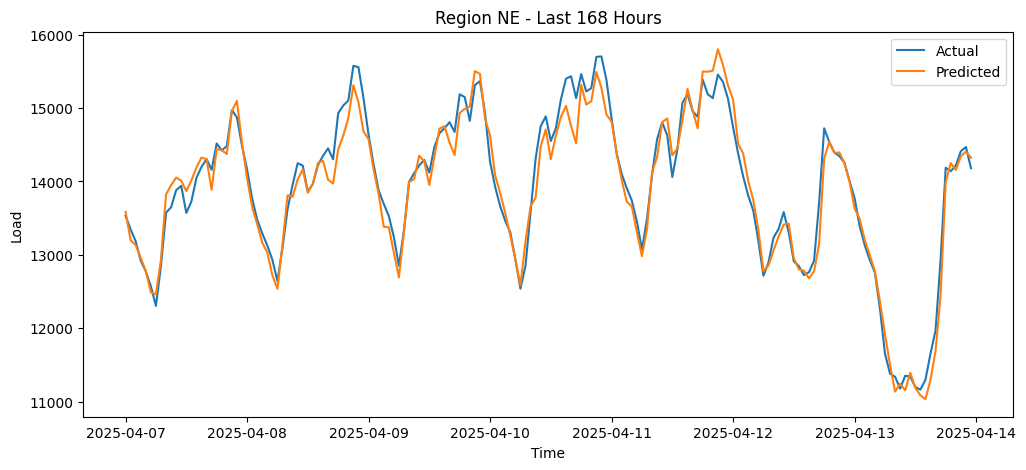


=== Region S ===
Train RMSE: 141.93
Val RMSE:   266.04
Test RMSE:  377.64


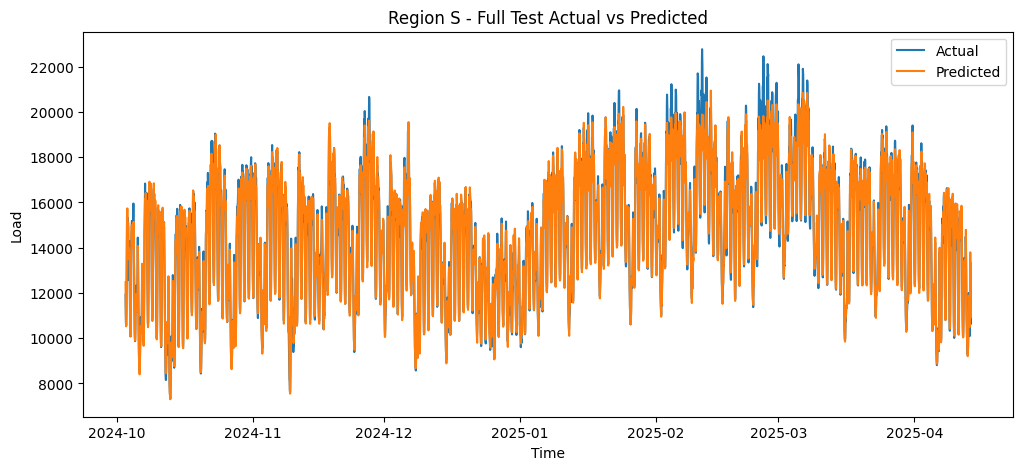

MAE Last 24h: 238.06


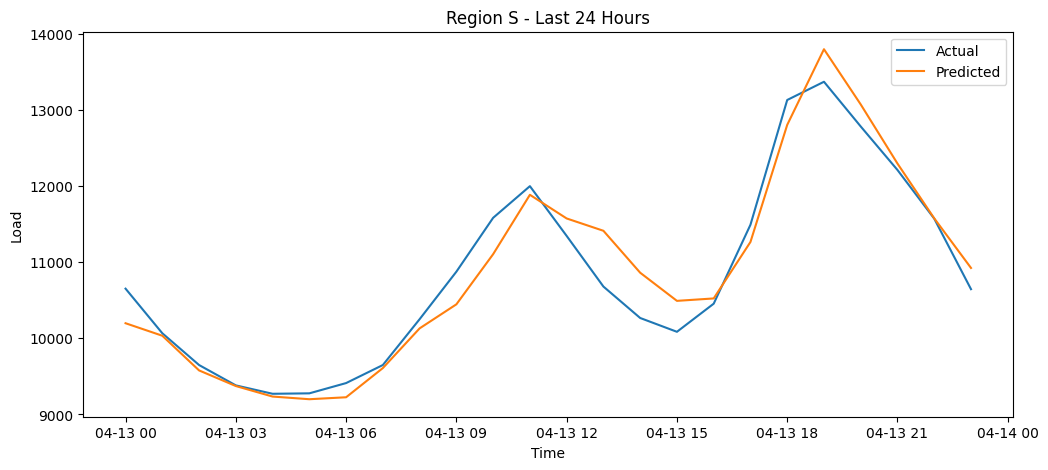

MAE Last 168h: 213.40


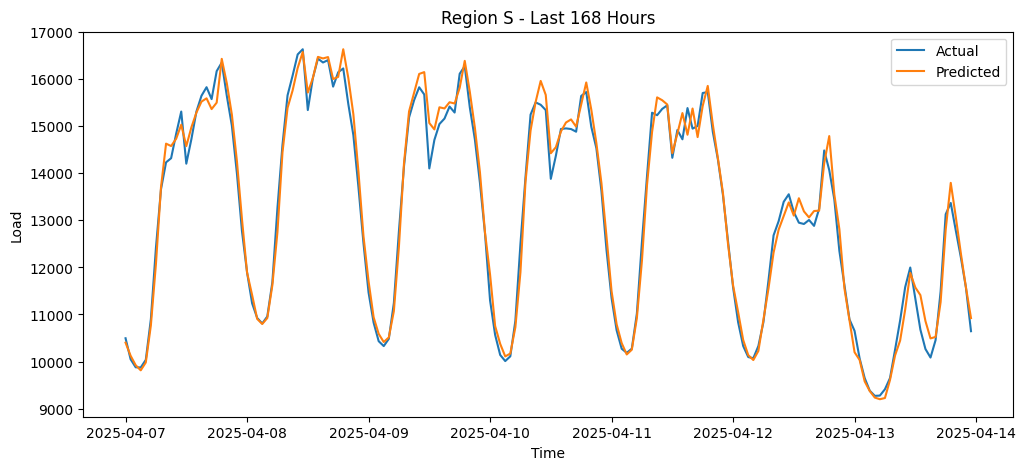


=== Region SE ===
Train RMSE: 297.55
Val RMSE:   487.31
Test RMSE:  589.19


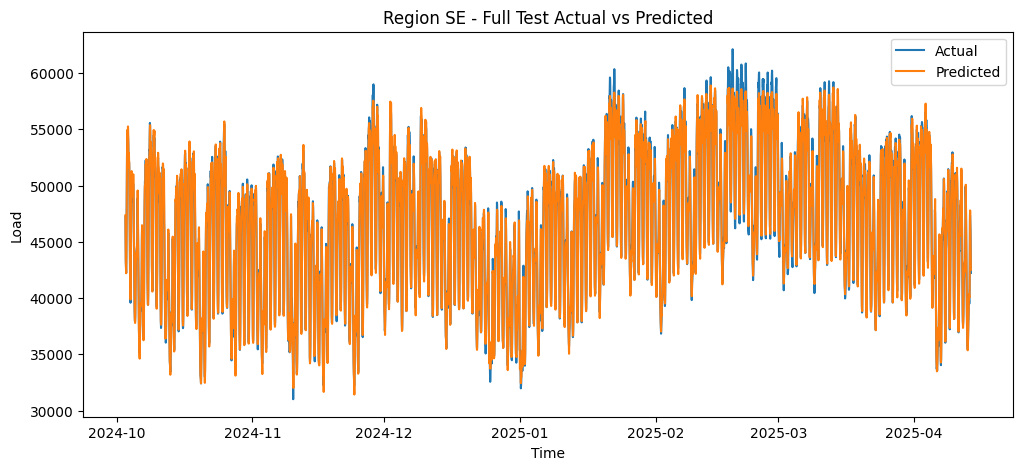

MAE Last 24h: 309.82


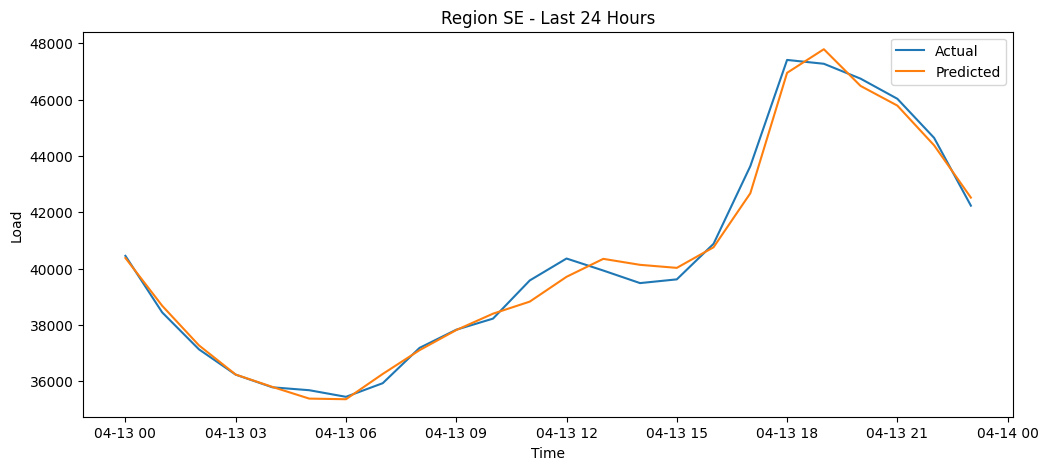

MAE Last 168h: 438.96


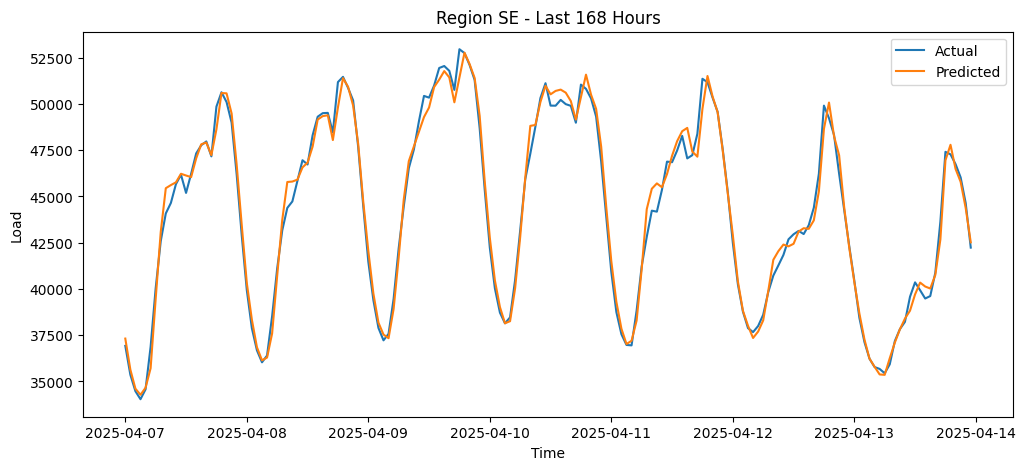

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

results = {}

param_grid = {
    'N':  [{'max_depth': 3, 'learning_rate': 0.05},
           {'max_depth': 4, 'learning_rate': 0.05}],

    'NE': [{'max_depth': 4, 'learning_rate': 0.05},
           {'max_depth': 5, 'learning_rate': 0.03}],

    'S':  [{'max_depth': 4, 'learning_rate': 0.03},
           {'max_depth': 5, 'learning_rate': 0.02}],

    'SE': [{'max_depth': 5, 'learning_rate': 0.02},
           {'max_depth': 6, 'learning_rate': 0.01}]
}


def plot_series(actual, pred, region, title):
    """Make actual & predicted share the same index correctly."""
    pred_series = pd.Series(pred, index=actual.index)

    plt.figure(figsize=(12,5))
    plt.plot(actual.index, actual.values, label='Actual')
    plt.plot(pred_series.index, pred_series.values, label='Predicted')
    plt.title(f"Region {region} - {title}")
    plt.xlabel("Time")
    plt.ylabel("Load")
    plt.legend()
    plt.show()



# -----------------------------------
# Train + Evaluate for each region
# -----------------------------------
for region, data in Regions_split_final.items():

    X_train = data['X_train']
    y_train = data['y_train']
    X_val   = data['X_val']
    y_val   = data['y_val']
    X_test  = data['X_test']
    y_test  = data['y_test']

    best_val_rmse = np.inf
    best_model = None

    # Hyperparameter search
    for params in param_grid[region]:

        model = XGBRegressor(
            n_estimators=2000,
            learning_rate=params['learning_rate'],
            max_depth=params['max_depth'],
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42,
            reg_alpha=0.2,
            reg_lambda=1.0,
            tree_method='hist'
        )

        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        val_rmse = np.sqrt(mean_squared_error(y_val, model.predict(X_val)))

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model = model

    # Final evaluation
    train_rmse = np.sqrt(mean_squared_error(y_train, best_model.predict(X_train)))
    test_pred = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

    # Save results
    results[region] = {
        'model': best_model,
        'train_rmse': train_rmse,
        'val_rmse': best_val_rmse,
        'test_rmse': test_rmse,
        'test_pred': test_pred
    }

    print(f"\n=== Region {region} ===")
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Val RMSE:   {best_val_rmse:.2f}")
    print(f"Test RMSE:  {test_rmse:.2f}")

    # ----------------------------
    # Plot Full Test
    # ----------------------------
    plot_series(y_test, test_pred, region, "Full Test Actual vs Predicted")

    # ----------------------------
    # Last 24 hours
    # ----------------------------
    last_24_actual = y_test[-24:]
    last_24_pred   = test_pred[-24:]

    mae_24 = mean_absolute_error(last_24_actual, last_24_pred)
    print(f"MAE Last 24h: {mae_24:.2f}")

    plot_series(last_24_actual, last_24_pred, region, "Last 24 Hours")

    # ----------------------------
    # Last 168 hours
    # ----------------------------
    last_168_actual = y_test[-168:]
    last_168_pred   = test_pred[-168:]

    mae_168 = mean_absolute_error(last_168_actual, last_168_pred)
    print(f"MAE Last 168h: {mae_168:.2f}")

    plot_series(last_168_actual, last_168_pred, region, "Last 168 Hours")



In [ ]:
from sklearn.metrics import mean_absolute_error

print("\n====== MAE for Each Region ======\n")

mae_results = {}

for region, info in results.items():
    model = info['model']


    X_train = Regions_split_final[region]['X_train']
    y_train = Regions_split_final[region]['y_train']
    X_val   = Regions_split_final[region]['X_val']
    y_val   = Regions_split_final[region]['y_val']
    X_test  = Regions_split_final[region]['X_test']
    y_test  = Regions_split_final[region]['y_test']


    train_pred = model.predict(X_train)
    val_pred   = model.predict(X_val)
    test_pred  = model.predict(X_test)


    train_mae = mean_absolute_error(y_train, train_pred)
    val_mae   = mean_absolute_error(y_val, val_pred)
    test_mae  = mean_absolute_error(y_test, test_pred)

    mae_results[region] = {
        "train_mae": train_mae,
        "val_mae": val_mae,
        "test_mae": test_mae
    }

    print(f"=== Region {region} ===")
    print(f"Train MAE: {train_mae:.2f}")
    print(f"Val MAE:   {val_mae:.2f}")
    print(f"Test MAE:  {test_mae:.2f}\n")



====== MAE for Each Region ======

=== Region N ===
Train MAE: 45.80
Val MAE:   98.61
Test MAE:  101.61

=== Region NE ===
Train MAE: 60.38
Val MAE:   116.57
Test MAE:  179.70

=== Region S ===
Train MAE: 103.73
Val MAE:   192.83
Test MAE:  250.82

=== Region SE ===
Train MAE: 218.65
Val MAE:   360.40
Test MAE:  424.28



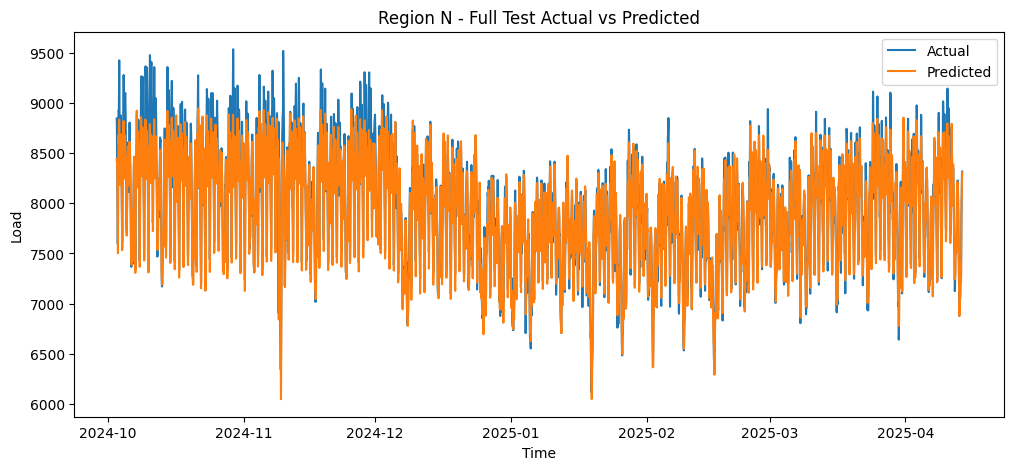

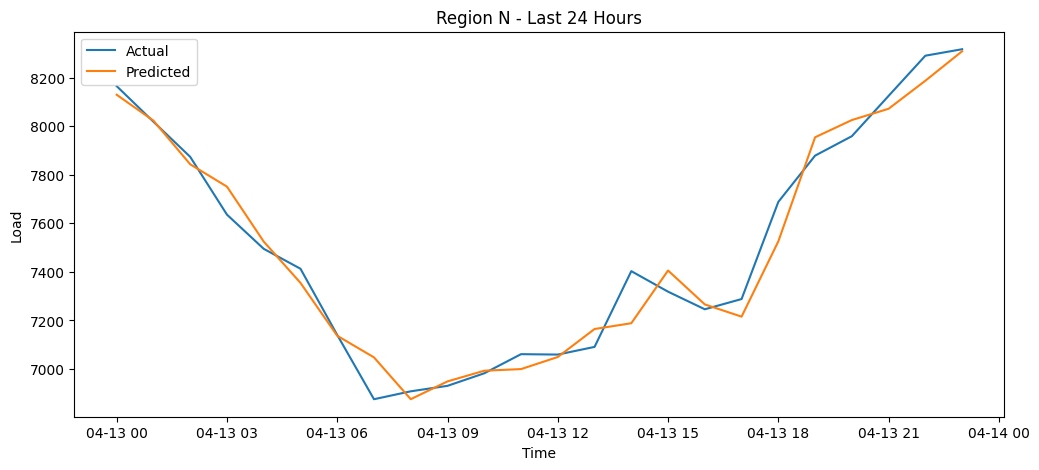

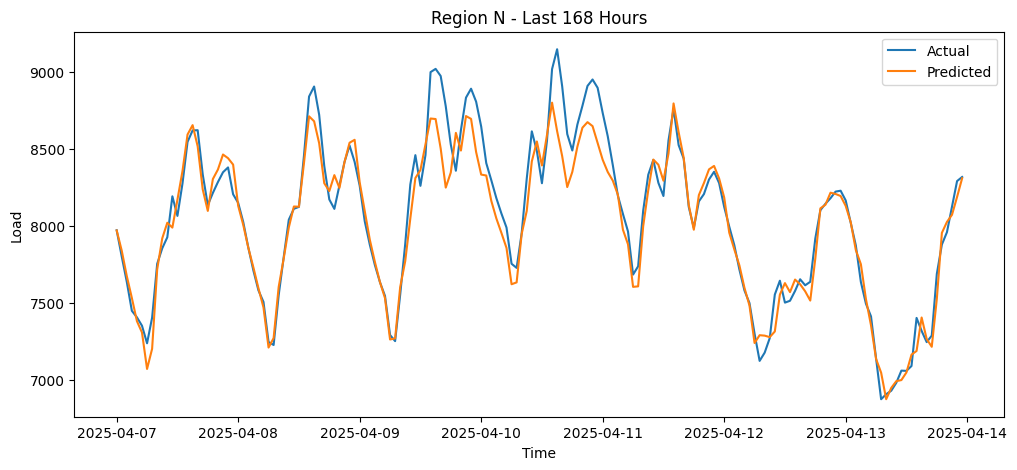

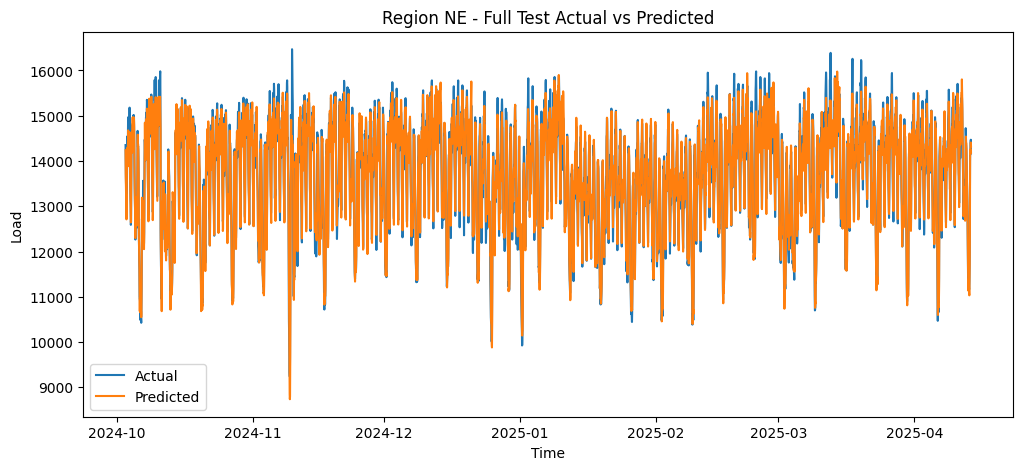

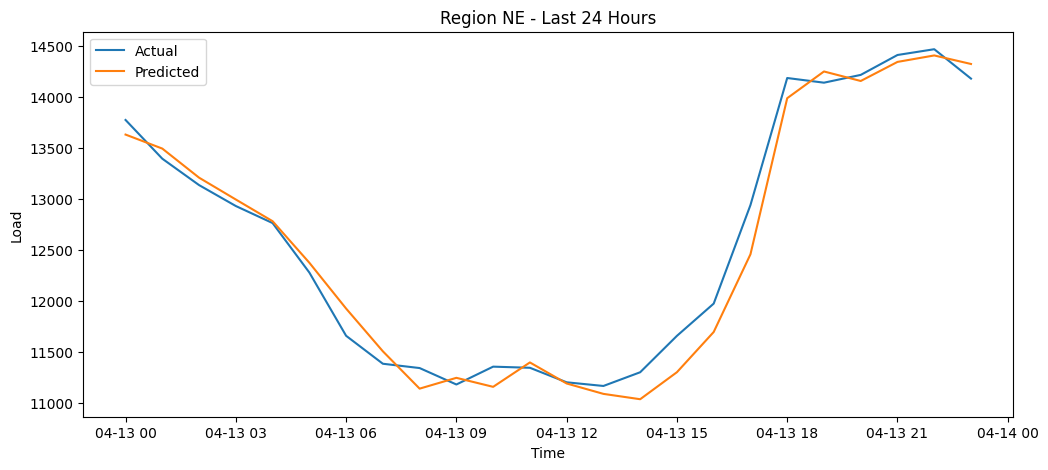

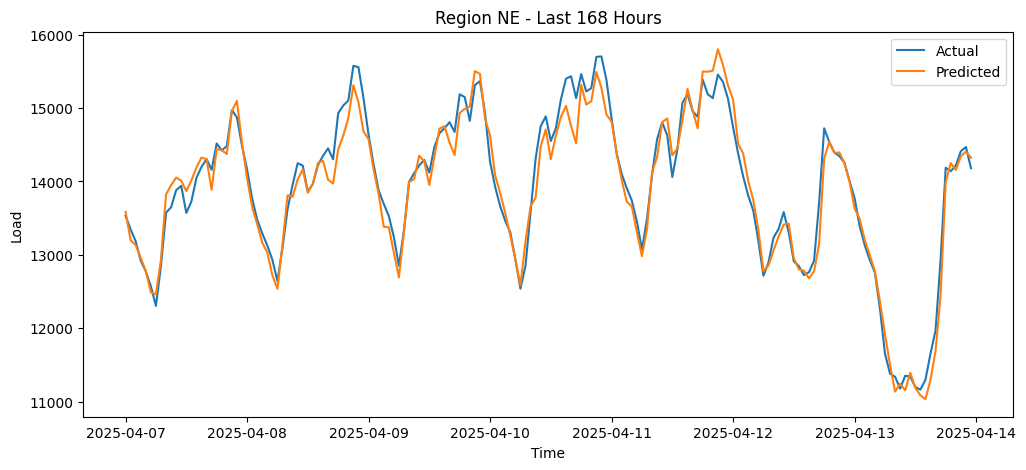

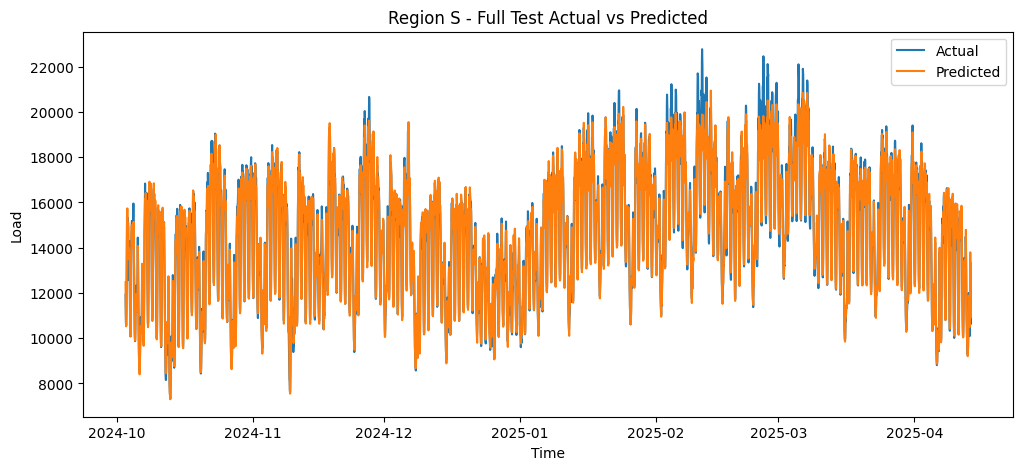

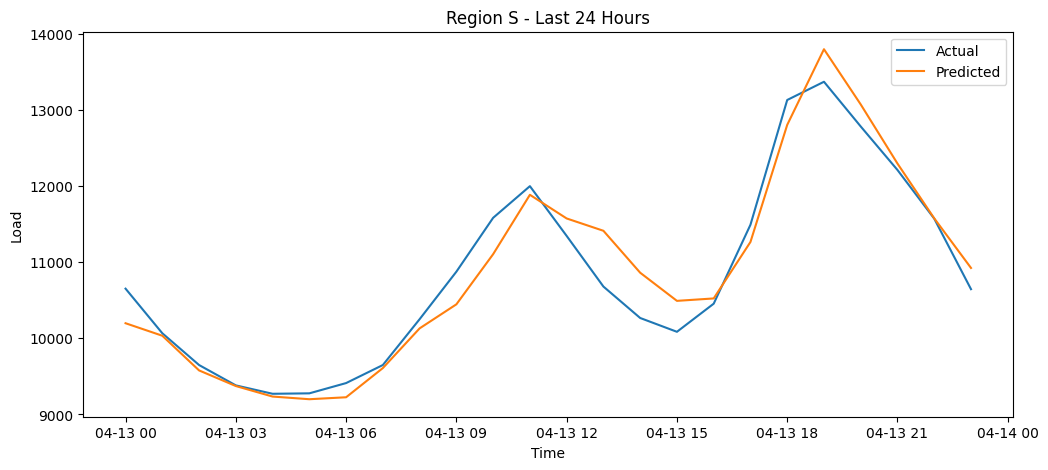

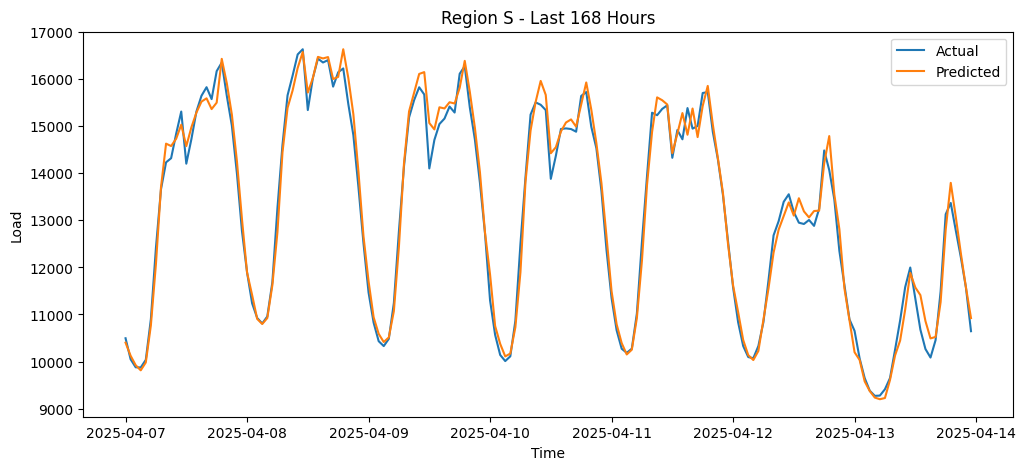

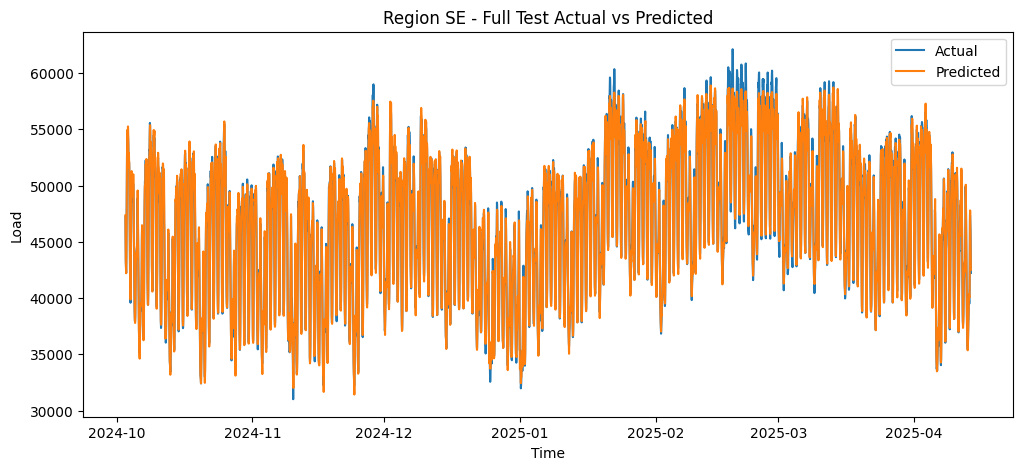

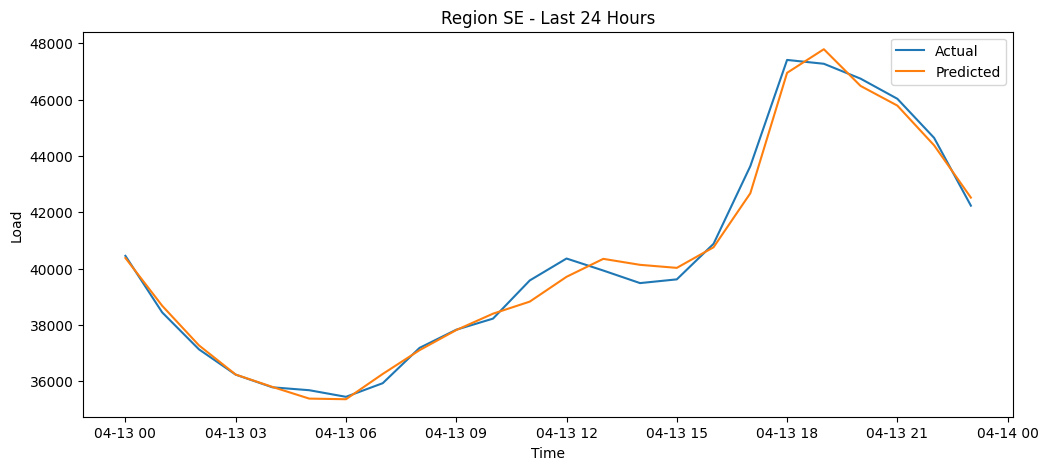

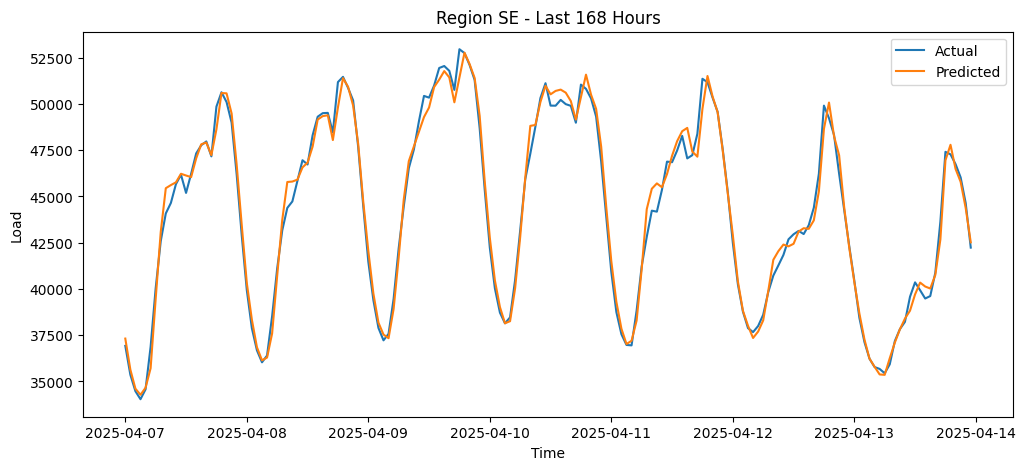


All plots saved successfully!


In [ ]:




def save_plot(actual, pred, region, title, filename):
    pred_series = pd.Series(pred, index=actual.index)

    plt.figure(figsize=(12,5))
    plt.plot(actual.index, actual.values, label='Actual')
    plt.plot(pred_series.index, pred_series.values, label='Predicted')
    plt.title(f"Region {region} - {title}")
    plt.xlabel("Time")
    plt.ylabel("Load")
    plt.legend()

    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()



for region, info in results.items():

    model_name = "xgboost"

    y_test = Regions_split_final[region]['y_test']
    test_pred = info['test_pred']

    # -------- Full Test ----------
    filename_full = f"{model_name}_{region}_full_test.png"
    save_plot(y_test, test_pred, region, "Full Test Actual vs Predicted", filename_full)

    # -------- Last 24 hours -------
    last_24_actual = y_test[-24:]
    last_24_pred = test_pred[-24:]

    filename_24 = f"{model_name}_{region}_24h.png"
    save_plot(last_24_actual, last_24_pred, region, "Last 24 Hours", filename_24)

    # -------- Last 168 hours ------
    last_168_actual = y_test[-168:]
    last_168_pred = test_pred[-168:]

    filename_168 = f"{model_name}_{region}_168h.png"
    save_plot(last_168_actual, last_168_pred, region, "Last 168 Hours", filename_168)

print("\nAll plots saved successfully!")
